In [1]:
import csv
import pandas as pd
import sys
import psycopg2
import gp
import time
import numpy as np
import spacy
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import fasttext
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import json
import datetime
import pickle

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

from google.cloud import bigquery
from google.cloud.bigquery import SchemaField

%config InlineBackend.figure_format='retina'

In [ ]:
print(icodf[['Name', 'Open Date (GMT)', 'Close Date (GMT)', 'subreddits']])

In [ ]:
# setup db connection

dbname = 'christle'
username = 'christle'
pswd = gp.get_psql_password()

engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)


In [ ]:
# query:
sql_query = """
SELECT COUNT(*) as comments, subreddit
FROM comments
GROUP BY 2
ORDER BY 1 DESC;
"""
t1 = time.time()
birth_data_from_sql = pd.read_sql_query(sql_query,con)
t2 = time.time()

print('Returned in {} s.'.format(t2-t1))
print(birth_data_from_sql['comments'])

In [ ]:
# test get all posts from subreddit

subreddit_post_object = get_subreddit_posts('Agrello', con, limit = 5000)
print(subreddit_post_object)

In [ ]:
t1 = time.time()
print(get_posts_containing(['XMR'], con, 200))
t2 = time.time()
print('Returned in {:.2f} seconds.'.format(t2-t1))

In [ ]:
# START NLP OF REDDIT TEXT FOR FASTTEXT CLASSIFIER

nlp = spacy.load('en')                 # You are here.
doc = nlp(u'Hello, spacy!')            # See "Using the pipeline"
print([(w.text, w.pos_) for w in doc]) # See "Doc, Span and Token"

doc = nlp(u'Hello, world! A three sentence document.\nWith new lines...')

In [ ]:
# create list of names, subreddits, and tickers

coin_inputs = []

#print(icodf[['Name', 'Asset', 'subreddits']].dropna())

for elem in icodf[['Name', 'Asset', 'subreddits']].dropna().values.tolist():
    if elem[2] == 'none':
        elem[2] = ''
    list_elem = [elem[0], elem[1], [x.strip() for x in elem[2].split(',')]]
    coin_inputs.append(list_elem)
    
#print(coin_inputs)

In [ ]:

# do we want to query over the entire db using regexp if too few elements are found? (takes a long time)
FULL_REGEXP_QUERY = False
# open a file handle for writing 
textfile_name = 'textfile.txt'
workfile_random_name = 'workfile_scrambled.txt'

f = open(textfile_name, 'w')

for coin in coin_inputs:
    print('Processing {}...'.format(coin[0]))
    ip = 0
    proper_coin_label = coin[0].strip().lower().replace(" ", "")
    # iterate over the 'label' subreddits first
    for sr_elem in coin[2]:
        if sr_elem != '':
            t1 = time.time()
            subreddit_post_object = get_subreddit_posts(sr_elem, con, limit = 50000)
            t2 = time.time()
        else:
            subreddit_post_object = False

        if sr_elem != '' and not subreddit_post_object.empty:
            print('Got {:d} objects in {:.1f} s.'.format(len(subreddit_post_object), t2-t1))
            for index, row in subreddit_post_object.iterrows():
                if ip % 5000 == 0 and ip > 0:
                    print('{} entries processed...'.format(ip))
                # use spacy for document lemmatization
                post_doc = row[0]
                post_doc = post_doc.replace('\n','')
                post_doc = post_doc.replace('\r','')
                post_doc = post_doc.replace(')','')
                post_doc = post_doc.replace('(','')
                label = '__label__' + sr_elem.lower() + ' '
                text_line = label + post_doc.lower()
                if len(post_doc) > 3 and row[0].strip() != '':
                    print(text_line, file=f)
                    ip += 1
        else:
            print('No objects found in subreddit {}.'.format(sr_elem))
    
    if ip < 5000 and FULL_REGEXP_QUERY:
        print('Too few samples ({}) -- querying reddit db based on regexp...'.format(ip))
        # if we have too few posts, we need to search all of reddit by a regexp to get
        # a decent number of samples for the text classifier
        
        # query the ticker
        query = [str(coin[0]) + ' ico', str(coin[1]) + ' ico', str(coin[0]) + ' token', str(coin[1]) + ' token']
        print('Querying asset symbol and name "{}"...'.format(query))
        t1 = time.time()
        subreddit_post_object = get_posts_containing(query, con, limit = 50000, timeout = 250000)
        t2 = time.time()
        
        if not subreddit_post_object.empty:
            print('Got {:d} objects in {:.1f} s.'.format(len(subreddit_post_object), t2-t1))
            for index, row in subreddit_post_object.iterrows():
                if ip % 5000 == 0 and ip > 0:
                    print('{} entries processed...'.format(ip))
                # use spacy for document lemmatization
                post_doc = row[0]
                post_doc = post_doc.replace('\n','')
                post_doc = post_doc.replace('\r','')
                post_doc = post_doc.replace(')','')
                post_doc = post_doc.replace('(','')
                label = '__label__' + sr_elem.lower() + ' '
                text_line = label + post_doc.lower()
                if len(post_doc) > 30:
                    print(text_line, file=f)
                ip += 1
        else:
            print('No objects found for regexp query {}.'.format(query))
            
        print('Processed a total of {} samples.'.format(ip))
        
f.close()


In [ ]:
# START USING FASTTEXT WRAPPER
import fasttext

epoch_array = [1, 2, 5, 10, 20, 30 , 50, 100]

for epoch_elem in epoch_array:
    print('Epoch is: {}'.format(epoch_elem))
    classifier = fasttext.supervised('wfs.train', 'model', epoch = epoch_elem)
    result = classifier.test('wfs.valid')
    print('P@1: {:.4f}'.format(result.precision))
    print('R@1: {:.4f}'.format(result.recall))
    print('Number of examples: {:d}'.format(result.nexamples))
    


In [ ]:
# SCORE ANALYSIS FUNCTION DEFINITIONS




In [ ]:
print(pd.Series([[2122, 'nullc'], [1119, 'evoorhees'], [908, 'luke-jr'], [774, 'Throwahoymatie'], [718, 'Introshine'], [700, 'BashCo'], [699, 'petertodd'], [664, 'pb1x'], [623, 'Vibr8gKiwi'], [588, 'paleh0rse'], [562, 'GibbsSamplePlatter'], [554, 'BobAlison'], [489, 'ferroh'], [486, 'ToTheMoonGuy'], [476, 'killerstorm'], [475, 'belcher_'], [467, 'jratcliff63367'], [446, 'theymos'], [441, 'PotatoBadger'], [439, 'jmw74'], [438, 'cap2002'], [424, 'usrn'], [422, 'bruce_fenton'], [415, 'Cryptolution'], [402, 'physalisx'], [400, 'spottedmarley'], [392, 'Sugar_Daddy_Peter'], [386, 'maaku7'], [379, 'AnalyzerX7'], [375, 'throwaway-o'], [373, 'bitusher'], [363, 'dellintelbitcoin'], [362, 'BitttBurger'], [356, 'IkmoIkmo'], [350, 'gavinandresen'], [348, 'Frogolocalypse'], [339, 'SeansOutpost'], [337, 'rydan'], [328, 'dskloet'], [327, 'waxwing'], [326, 'xrandr'], [315, 'ferretinjapan'], [311, 'kinoshitajona'], [307, 'Noosterdam'], [304, 'Piper67'], [301, 'gonzobon'], [294, 'Frankeh'], [293, 'throckmortonsign'], [291, 'smartfbrankings'], [289, 'pizzaface18'], [284, 'Natanael_L'], [282, 'kryptomancer'], [282, 'Cowboy_Coder'], [281, 'aminok'], [281, 'thieflar'], [280, 'jcoinner'], [277, 'totes_meta_bot'], [273, 'AstarJoe'], [272, 'Julian702'], [271, 'kiisfm'], [270, 'ztsmart'], [265, 'lifeboatz'], [265, 'slowmoon'], [262, 'supermari0'], [262, 'sreaka'], [261, 'TheSelfGoverned'], [257, 'riplin'], [254, 'whitslack'], [254, 'Lite_Coin_Guy'], [253, 'cypherdoc2'], [253, 'Logical007'], [250, 'knight222'], [249, 'eragmus'], [249, 'conv3rsion'], [249, 'Amanojack'], [248, 'chrisrico'], [247, 'MyDixieWreck4BTC'], [246, 'Thorbinator'], [245, 'moral_agent'], [245, 'hugolp'], [245, 'muyuu'], [239, 'd4d5c4e5'], [239, 'zeusa1mighty'], [238, 'btchombre'], [235, 'ebaley'], [235, 'Anenome5'], [234, 'tophernator'], [233, 'chalash'], [233, 'cqm'], [233, 'trilli0nn'], [226, 'Sovereign_Curtis'], [225, 'prelsidente'], [224, 'bubbasparse'], [223, 'yorrick21'], [222, '_niko'], [222, 'NimbleBodhi'], [220, 'murbul'], [217, 'hardleft121'], [216, 'bitpotluck'], [215, 'Shibinator'], [215, 'pluribusblanks'], [214, 'nobodybelievesyou'], [214, 'adam3us'], [214, 'nopara73'], [212, 'xcsler'], [212, 'elux'], [212, 'pdtmeiwn'], [210, 'Dude-Lebowski'], [209, 'drcross'], [209, 'zoopz'], [209, 'moleccc'], [208, 'marcus_of_augustus'], [207, 'yeh-nah-yeh'], [207, 'Essexal'], [206, 'violencequalsbad'], [205, 'hairy_unicorn'], [205, 'danielravennest'], [203, 'stcalvert'], [202, 'gizram84'], [201, 'digitalh3rmit'], [198, 'statoshi'], [198, 'pyalot'], [197, 'cpgilliard78'], [196, 'flamingboard'], [195, 'Lentil-Soup'], [194, 'sgornick'], [193, 'secret_bitcoin_login'], [192, 'mike_hearn'], [192, 'jonny1000'], [191, 'AnonymousRev'], [191, 'ConditionDelta'], [190, 'Lejitz'], [190, 'KoKansei'], [190, 'vakeraj'], [190, 'coastermonger'], [190, 'vbenes'], [189, 'bitcoind3'], [188, 'blackmarble'], [188, 'tsontar'], [187, 'i_can_get_you_a_toe'], [185, 'mmeijeri'], [185, 'UKcoin'], [183, 'chriswheeler'], [183, 'paperraincoat'], [183, 'SatoshisCat'], [183, 'dooglus'], [182, 'PoliticalDissidents'], [182, 'zombiecoiner'], [181, 'Chakra_Scientist'], [181, 'cryptonaut420'], [181, 'runeks'], [181, 'bbbbbubble'], [178, 'SatoshisGhost'], [178, 'kwanijml'], [176, 'GSpotAssassin'], [175, 'Yoghurt114'], [174, 'Rassah'], [173, 'n0mdep'], [173, 'vbuterin'], [173, 'jgarzik'], [173, 'oakpacific'], [171, 'paavokoya'], [171, 'Bitcoinopoly'], [171, 'rmvaandr'], [170, 'bitsteiner'], [170, 'stormsbrewing'], [169, 'twfry'], [168, 'BeastmodeBisky'], [168, 'Aahzmundus'], [167, 'goonsack'], [165, 'wserd'], [165, 'dillpicklechips'], [163, 'Taek42'], [163, 'btcdrak'], [162, 'futilerebel'], [162, 'xygo'], [162, 'anaccountjustforyouu'], [161, 'Capt_Roger_Murdock'], [160, 'bitcointip'], [160, 'notreddingit'], [159, 'sumBTC'], [158, 'chuckymcgee'], [158, 'CC_EF_JTF'], [158, 'sQtWLgK'], [158, '7trXMk6Z'], [157, 'targetpro'], [157, 'canad1andev3loper'], [156, 'Cryptoconomy'], [155, 'arcrad'], [154, 'ebliever'], [153, 'giszmo'], [153, 'sqrt7744'], [153, 'jrmxrf'], [152, 'token_dave'], [152, 'andreasma'], [151, 'Yorn2'], [151, 'Anen-o-me'], [151, 'Future_Prophecy'], [151, 'handsomechandler']]))

In [ ]:
expertdf = pd.DataFrame()




In [ ]:
import datetime
import time



for i, row in icodf.iterrows():
    x = row['Close Date (GMT)']
    t = datetime.datetime.strptime(x, '%m/%d/%Y')
    print(int(time.mktime(t.timetuple())))

In [ ]:
# EXPLORATORY ANALYSIS OF UPVOTES/SCORES IN A CRYPTOCURRENCY SUBREDDIT


# write a function that returns the total number of posts before an ICO within the subreddit of interest + regexp

# get the counts from many tables
client = bigquery.Client.from_service_account_json(
        '/Users/christle/insight_project/chicagoproject.json')



In [ ]:
pd.set_option('display.max_rows', 5000)
print(icodf_filtered[['Name', 'subreddits']])
icodf_filtered.loc[icodf_filtered['Name'] == 'Wings', 'subreddits'] = 'WingsDAO'
icodf_filtered.loc[icodf_filtered['Name'] == 'Ark', 'subreddits'] = 'ArkEcosystem'

In [ ]:
# PRINT ENTIRE ICODF
pd.set_option('display.max_rows', 1000)
print(icodf_filtered[['Name', 'subreddits', 'total_comments', 'ICO Size ($m)']])
#plt.plot(icodf_filtered['ICO Size ($m)'], icodf_filtered['total_comments'])
plt.show()
#



In [ ]:


ico_temp = icodf_filtered.drop(icodf_filtered[icodf_filtered['total_comments'] >= 50000].index)

plt.scatter(ico_temp['total_comments'], ico_temp['ICO Size ($m)'], s=40, c='b', marker='o')
plt.xlabel('Total Comments')
plt.ylabel('ICO Size ($m)')
plt.savefig('size_vs_comments.png', bbox_inches='tight')
plt.show()

plt.scatter(ico_temp['has_a_subreddit'] + np.random.normal(size=np.shape(ico_temp['has_a_subreddit']))*0.05, ico_temp['ICO Size ($m)'], s=40, c='b', marker='o')
plt.xlabel('Does it have a subreddit?')
plt.ylabel('ICO Size ($m)')
plt.savefig('hassubreddit_vs_comments.png', bbox_inches='tight')
plt.show()

plt.scatter(ico_temp['cumulative_raised'] + np.random.normal(size=np.shape(ico_temp['cumulative_raised']))*0.2, ico_temp['ICO Size ($m)'], s=40, c='b', marker='o')
plt.xlabel('Cumulative ICO Raises ($m)')
plt.ylabel('ICO Size ($m)')
plt.savefig('cumulative_vs_comments.png', bbox_inches='tight')
plt.show()

plt.scatter(ico_temp['closed_utc'] + np.random.normal(size=np.shape(ico_temp['cumulative_raised']))*0.2, ico_temp['ICO Size ($m)'], s=40, c='b', marker='o')
plt.xlabel('Time of ICO (UTC time since Jan 1 1970)')
plt.ylabel('ICO Size ($m)')
plt.savefig('utctime_vs_comments.png', bbox_inches='tight')
plt.show()

print(ico_temp[['Name', 'total_comments']])

In [ ]:
# SAVE ICODF FILTERED TO A FILE

icodf_filtered.to_csv('icodf_filtered.csv', index=False)

In [ ]:
# LOAD ICODF FILTERED FROM A FILE


icodf_filtered = pd.read_csv('icodf_filtered.csv')

print(icodf_filtered)

In [ ]:
# WRITE ICODF TO POSTGRES

In [ ]:
# GET THE FEATURES WE CARE ABOUT AND PUT THEM IN A NUMPY ARRAY

model_data = icodf_filtered[['Name', 'total_comments', 'has_a_subreddit', 'closed_utc', 'cumulative_raised', 'ICO Size ($m)']]

#print(model_data)

X_data = model_data[['total_comments', 'has_a_subreddit', 'closed_utc', 'cumulative_raised']].values
Y_data = model_data[['ICO Size ($m)']].values

# log transform number of comments
X_data[:,0] = np.log(X_data[:,0]+1.0)

Y_data = np.reshape(Y_data, newshape=(np.size(Y_data),))
#print(Y_data)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_data)

X_transformed = scaler.transform(X_data)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X_transformed, Y_data, test_size=0.4, random_state=0)

X_train.shape, y_train.shape

X_test.shape, y_test.shape




In [ ]:
from sklearn.svm import SVR
for C_val in [1, 10, 100, 1000, 2000, 5000, 10000]:
    for gam_val in [0.01, 0.01, 0.1, 0.2, 1, 2]:
        
        clf = SVR(kernel='rbf', C=C_val, gamma=gam_val)
        clf.fit(X_transformed, Y_data)
        print('C: {} gamma: {} -- score: {:.2f}'.format(C_val, gam_val, clf.score(X_test, y_test)))

clf = SVR(kernel='rbf', C=10, gamma=0.1)
clf.fit(X_transformed, Y_data)
prediction = clf.predict(X_transformed)

plt.scatter(prediction, Y_data, s=40, c='b', marker='o')
plt.xlabel('Predicted ICO Size ($m)')
plt.ylabel('Actual ICO Size ($m)')
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

SS = MinMaxScaler()

SS.fit(X_data)

X_transformed = np.copy(SS.transform(X_data))
Y_values = np.copy(np.log(0.01 + Y_data)/np.log(10.0))
print(X_transformed)

In [ ]:
import xgboost as xgbb
from xgboost import XGBClassifier  
from xgboost import XGBRegressor


c_array = [ 0.1, 0.2, 0.5, 0.7, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0,  5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 1200.0, 1500.0, 1700.0, 2000.0, 2300.0]
gam_array = [ 0.001,  0.01, 0.1, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5]
param_grid = [[x, y] for x in c_array for y in gam_array]

c_array = [ 0.005, 0.01, 0.05, 0.1, 0.2]
gam_array = [ 5, 8, 10, 20, 30, 50]
mv_array = [2, 3, 4, 5]
param_grid = [[x, y, z] for x in c_array for y in gam_array for z in mv_array]

mv = 0
for c_val, gam_val, mv in param_grid:
    n_spl = 5
    skf = KFold(n_splits=n_spl)
    tr_sc = 0.0
    te_sc = 0.0
    for train_ind, test_ind in skf.split(X_transformed, Y_values.ravel()):
        X_tr, X_te = X_transformed[train_ind], X_transformed[test_ind]
        y_tr, y_te = Y_values[train_ind], Y_values[test_ind]
        #print(' {} {} '.format(np.shape(X_tr),np.shape(y_tr)))
        # SVMs -- linear and rbf kernels
        #fare_svr = svm.SVR(kernel='linear', C=c_val, gamma=gam_val)
        #fare_svr = svm.SVR(kernel='rbf', C=c_val, gamma=gam_val)

        #fare_svr.fit(X_tr,y_tr)
        
        # Gradient Boosting
        #fare_svr = GradientBoostingRegressor(loss='ls', learning_rate=c_val,  n_estimators=gam_val, max_depth=mv)
        #fare_svr.fit(X_tr, y_tr)
        
        #XGBoost
        fare_svr = xgbb.XGBRegressor(learning_rate=c_val,  n_estimators=gam_val, max_depth=mv, n_jobs=4)
        fare_svr.fit(X_tr, y_tr)
        
        tr_sc = tr_sc + fare_svr.score(X_tr,y_tr)
        te_sc = te_sc + fare_svr.score(X_te,y_te)
    if te_sc > -1:
        print('c/gam/m: {} {} {} , Train/test accuracies: {:.5f} / {:.5f}'.format(c_val, gam_val, mv, tr_sc/float(n_spl), te_sc/float(n_spl)))


In [ ]:
from sklearn.feature_selection import RFE

#LINEAR SVM

#fare_svr = svm.SVR(kernel='linear', C = 0.7)

#RBF 
#fare_svr = svm.SVR(kernel='rbf', C=1, gamma=0.5)

#GBR

#fare_svr = GradientBoostingRegressor(loss='ls', learning_rate=0.2,  n_estimators=8, max_depth=1)

#XGBOOST
fare_svr = xgbb.XGBRegressor(learning_rate=0.2,  n_estimators=8, max_depth=2, n_jobs=4)

fare_svr.fit(X_transformed, Y_values)
prediction = fare_svr.predict(X_transformed)

# RFE (only works for linear kernel)
#selector = RFE(fare_svr, 5, step=1)
#selector = selector.fit(X_transformed, Y_values)
#print('selector support: {}'.format(selector.support_))
#print('selector ranking: {}'.format(selector.ranking_))

# XGBOOST FEATURE IMPORTANCE

print(fare_svr.feature_importances_)


# transformation: Y_values = np.copy(np.log(0.01 + Y_data)/np.log(10.0))

x_identical = np.linspace(-0.7,1.9,100)
plt.scatter(prediction, Y_values, s=40, c='b', marker='o')
plt.plot(x_identical,x_identical, c='r')
plt.xlabel('LOG 10 Predicted ICO Size ($m)')
plt.ylabel('LOG 10 Actual ICO Size ($m)')
plt.savefig('ICO_log10_actual_vs_predicted.png', bbox_inches='tight')
plt.show()

x_identical = np.linspace(0,60,100)
plt.scatter(np.exp(np.log(10.0)*prediction)-0.01, np.exp(np.log(10.0)*Y_values)-0.01, s=40, c='b', marker='o')
plt.plot(x_identical,x_identical, c='r')
plt.xlabel('Predicted ICO Size ($m)')
plt.ylabel('Actual ICO Size ($m)')
plt.savefig('ICO_actual_vs_predicted.png', bbox_inches='tight')
plt.show()

print(icodf_filtered['Name'].tolist())

In [ ]:
# LOAD ICO PREDICTIONS INTO POSTGRES 

for i, row in icodf_filtered.iterrows():
    cur = con.cursor()
    cur.execute("""INSERT INTO icoprediction (coinname, assetname, closed_utc, raise_predict, raise_actual) VALUES ('{}', '{}', {:.1f}, {:.3f}, {:.3f});""".format(row['Name'], row['Asset'], row['closed_utc'], np.exp(np.log(10.0)*prediction[i])-0.01, row['ICO Size ($m)']))
    
con.commit()
cur.close()

In [ ]:
con.rollback()

In [ ]:
from json import JSONDecoder
from functools import partial


def json_parse(fileobj, decoder=JSONDecoder(), buffersize=2048):
    buffer = ''
    for chunk in iter(partial(fileobj.read, buffersize), ''):
         buffer += chunk
         while buffer:
             try:
                 result, index = decoder.raw_decode(buffer)
                 yield result
                 buffer = buffer[index:]
             except ValueError:
                 # Not enough data to decode, read more
                 break

In [ ]:
# LOAD BITCOINTALK.JSON INTO BITCOINTALK RELATION IN POSTGRES
# BIGGER FILE
# import json
# with open('/Users/christle/hitcoin/scraper/bitcointalk/bitcointalk_scraper/bitcointalk_proxy.json', 'r') as f:
#     bitcointalk = json.load(f)
# SMALLER FILE
# import json
# i = 0
# with open('/Users/christle/hitcoin/scraper/bitcointalk/bitcointalk_scraper/bitcointalk_last_import.json', 'r') as f:
#     json_data = json.loads(f)
dbname = 'christle'
username = 'christle'
pswd = gp.get_psql_password()

engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)


cur = con.cursor()


i = 0
import json 
with open('/Users/christle/hitcoin/scraper/bitcointalk/bitcointalk_scraper/bitcointalk_last_import.json', 'r') as f:
    for i, line in enumerate(f):
        if i > 0:
            if line[-1] == ',':
                line[-1] = ''
            stripped_line = line.rstrip(',\n]')
            if i % 50000 == 0:
                print('processed line {}...'.format(i))
            #print(stripped_line)
            try:
                js_line = json.loads(stripped_line)

                elem = js_line
                cur.execute("""INSERT INTO bitcointalklast (title, created_utc, topic_id, message_id, text) VALUES ('{}', '{:d}', '{:d}', '{}', '{}');""".format(elem['title'].replace("'","''"), int(elem['created_utc']), int(elem['topic_id']), elem['message_id'], elem['text'].replace("'","''")))
            except:
                print('json decode failed at line: {}'.format(i))
                break
            
            i = i + 1
        #if i > 50:
        #    break
con.commit()    
cur.close()
con.close()

In [ ]:
print(bitcointalk[100])

In [ ]:
# TEST OUT VADER SENTIMENT ANALYSIS

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

sentences = [
                "The plot was good, but the characters are uncompelling and the dialog is not great.", 
                "A really bad, horrible book.",       
                "At least it isn't a horrible book."
            ]
for sentence in sentences:
    print(sentence)
    sentiment = analyzer.polarity_scores(sentence)
    print("\n\t" + str(sentiment))

In [ ]:
# LOAD ICO PREDICTIONS INTO POSTGRES WITH VADERSENTIMENT

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

for i, elem in enumerate(bitcointalk):
    cur = con.cursor()
    sentiment = analyzer.polarity_scores(elem['text'].replace("'","''"))
    cur.execute("""INSERT INTO bitcointalk (title, created_utc, topic_id, message_id, bodytext, vadersentiment) VALUES ('{}', '{:d}', '{:d}', '{}', '{}', {:.3f});""".format(elem['title'].replace("'","''"), int(elem['created_utc']), int(elem['topic_id']), elem['message_id'], elem['text'].replace("'","''"), sentiment['compound']))
    if i % 2000 == 0:
        print('Processed {} rows...'.format(i))
    
con.commit()
cur.close()

In [ ]:
# TEST IF CERTAIN SENTENCES REALLY HAVE SENTIMENTS OF ZERO

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentiment = analyzer.polarity_scores('Some motivational graphics'.replace("'","''"))
print(sentiment)

In [ ]:
con.commit()
cur.close()

In [ ]:
# create a sentiment score for every comment in the psql db
for i, elem in enumerate(bitcointalk):
    cur = con.cursor()
    cur.execute("""INSERT INTO bitcointalk (title, created_utc, topic_id, message_id, bodytext) VALUES ('{}', '{:d}', '{:d}', '{}', '{}');""".format(elem['title'].replace("'","''"), int(elem['created_utc']), int(elem['topic_id']), elem['message_id'], elem['text'].replace("'","''")))


In [ ]:
# SERVER SIDE CURSOR FOR FETCHING POSTS FOR SENTIMENT ANALYSIS

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


#engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# server side cursor setup and execute
sscur = con.cursor(name='sentimentcursor')

QUERY = """
SELECT * FROM comments
LIMIT 19000000
"""
sscur.execute(QUERY)

cur = con.cursor()
i = 0
t1 = time.time()
with open('bulk_copy_dump.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar="'", quoting=csv.QUOTE_MINIMAL)
    for record in sscur:     # or cur2.fetchone, fetchmany...
        created_utc, subreddit, author, body, id_val, score, ups, downs, controversiality = record
        # compute sentiment using vader
        sentiment = analyzer.polarity_scores(body)
        try:
            # SQL INSERT 
            INSERT_QUERY = """INSERT INTO commentssentiment (created_utc, subreddit, author, body, id, score, ups, downs, controversiality, vadersentiment) VALUES ('{:d}', '{}', '{}', '{}', '{}', '{:d}', '{:d}', '{:d}', '{}', '{:.3f}');""".format(int(created_utc or 0), subreddit, author, body.replace("'","''"), id_val, score, ups, downs, controversiality, sentiment['compound'])
            cur.execute(INSERT_QUERY)
            
            # WRITE FILE FOR BULK COPY (SPEED)
            #csv_row_list = [created_utc, subreddit, author, body.replace("'","''"), id_val, score, ups, downs, controversiality, sentiment['compound']]
            
        except TypeError:
            # bad practice not to handle this, but happens once in ~5 million rows
            print(record)
            pass


        i += 1
        if i % 20000 == 0:
            print('{} rows processed, {:.1f} rows per second.'.format(i, float(i)/(time.time()-t1+0.01)))
        pass

con.commit()
con.close()

In [ ]:
# SERVER SIDE CURSOR FOR REDDIT POST SENTIMENT ANALYSIS


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


#engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# server side cursor setup and execute
sscur = con.cursor(name='sentimentcursor')

QUERY = """
SELECT * FROM posts
LIMIT 60000000
"""
sscur.execute(QUERY)

cur = con.cursor()
i = 0
t1 = time.time()
with open('bulk_copy_dump.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar="'", quoting=csv.QUOTE_MINIMAL)
    for record in sscur:     # or cur2.fetchone, fetchmany...
        created_utc, subreddit, author, selftext, domain, id_val, title, num_comments, score, ups, downs, subredditid = record
        #print(created_utc)
        # compute sentiment using vader
        sentiment = analyzer.polarity_scores(selftext)

        # SQL INSERT
        if subredditid is None:
            subredditid = 'none'
        INSERT_QUERY = """INSERT INTO postssentiment (created_utc, subreddit, author, selftext, domain, id, title, num_comments, score, ups, downs, subreddit_id, vadersentiment) VALUES ('{:d}', '{}', '{}', '{}', '{}', '{}', '{}', '{}', '{:d}', '{:d}', '{:d}', '{}', '{:.3f}');""".format(int(created_utc or 0), subreddit, author, str(selftext or '').replace('\n',' ').replace("'","''"), str(domain or '').replace('\n',' ').replace("'","''"), id_val, title.replace("'","''"), int(num_comments or 0), int(score or 0), int(ups or 0), int(downs or 0), str(subredditid or 0), sentiment['compound'])
        #print(INSERT_QUERY)
        cur.execute(INSERT_QUERY)


            
        i += 1
        if i % 20000 == 0:
            print('{} rows processed, {:.1f} rows per second.'.format(i, float(i)/(time.time()-t1+0.01)))
            #con.commit()
        pass

con.commit()
con.close()

In [ ]:
con.commit()
con.close()

In [ ]:
# SERVER SIDE CURSOR FOR BITCOINTALK SENTIMENT ANALYSIS - FROM PSQL


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


#engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# server side cursor setup and execute
sscur = con.cursor(name='sentimentcursor')

QUERY = """
SELECT * FROM bitcointalklast
LIMIT 5000000
"""
sscur.execute(QUERY)

cur = con.cursor()
i = 0
t1 = time.time()

for record in sscur:     # or cur2.fetchone, fetchmany...
    title, created_utc, topic_id, message_id, bodytext = record
    # compute sentiment using vader
    sentiment = analyzer.polarity_scores(bodytext)
    try:
        # SQL INSERT 
        INSERT_QUERY = """INSERT INTO bitcointalklastsentiment (title, created_utc, topic_id, message_id, text, vadersentiment) VALUES ('{}', '{:d}', '{}', '{}', '{}', '{:.3f}');""".format(title.replace("'","''"), int(created_utc or 0), topic_id, message_id, bodytext.replace("'","''"), sentiment['compound'])
        cur.execute(INSERT_QUERY)

        # WRITE FILE FOR BULK COPY (SPEED)
        #csv_row_list = [created_utc, subreddit, author, body.replace("'","''"), id_val, score, ups, downs, controversiality, sentiment['compound']]

    except TypeError:
        # bad practice not to handle this, but happens once in ~5 million rows
        print(record)
        pass


    i += 1
    if i % 20000 == 0:
        print('{} rows processed, {:.1f} rows per second.'.format(i, float(i)/(time.time()-t1+0.01)))
        t1 = time.time()
    pass

con.commit()
con.close()

In [ ]:
# SERVER SIDE CURSOR FOR BITCOINTALK SENTIMENT ANALYSIS - FROM CSV


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


#engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# server side cursor setup and execute
sscur = con.cursor(name='sentimentcursor')

QUERY = """
SELECT * FROM bitcointalklast
LIMIT 2000000
"""
sscur.execute(QUERY)

cur = con.cursor()
i = 0
t1 = time.time()
with open('bulk_copy_dump.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar="'", quoting=csv.QUOTE_MINIMAL)
    for record in sscur:     # or cur2.fetchone, fetchmany...
        title, created_utc, topic_id, message_id, bodytext = record
        # compute sentiment using vader
        sentiment = analyzer.polarity_scores(body)
        try:
            # SQL INSERT 
            INSERT_QUERY = """INSERT INTO bitcointalksentiment (title, created_utc, topic_id, message_id, bodytext, vadersentiment) VALUES ('{}', '{:d}', '{}', '{}', '{}', '{:.3f}');""".format(title, created_utc, topic_id, message_id, bodytext.replace("'","''"), sentiment['compound'])
            cur.execute(INSERT_QUERY)
            
            # WRITE FILE FOR BULK COPY (SPEED)
            #csv_row_list = [created_utc, subreddit, author, body.replace("'","''"), id_val, score, ups, downs, controversiality, sentiment['compound']]
            
        except TypeError:
            # bad practice not to handle this, but happens once in ~5 million rows
            print(record)
            pass


        i += 1
        if i % 2000 == 0:
            print('{} rows processed, {:.1f} rows per second.'.format(i, float(i)/(time.time()-t1+0.01)))
        pass

con.commit()
con.close()

# FINAL DATA PIPELINE BEGIN

In [ ]:
def load_ico_data():# load ICO data from CSV file
    icodf = pd.read_csv('icolist_processed.csv')

    icodf.loc[icodf['Name'] == 'Status','subreddits'] = 'status_token, statusim'

    icodf = icodf.sort_values(by=['ICO Size ($m)'], ascending=False)

    # LOAD JSON FROM TOKENDATA.IO

    with open('/Users/christle/hitcoin/tokendataio.json', 'r') as f:
        tokendataIO = json.load(f)

    tokendatadf = pd.DataFrame.from_dict(tokendataIO['data'])
    tddf = tokendatadf.copy()
    tddf['usd_raised'] = pd.to_numeric(tokendatadf['usd_raised'], errors='coerce')
    tddf = tddf.dropna(subset=['usd_raised'])
    tddf = tddf.sort_values(by=['usd_raised'] , ascending=False)
    #tddf['usd_raised'].to_numeric() / 1000000.0
    #print(tokendatadf.head())

    #
    dftoappend = pd.DataFrame([[0, 'Filecoin', '8/10/2017', '9/7/2017', 'filecoin.io', '', 'filecoin', 250.0, 'filecoin']], columns = icodf.columns)
    icodf = icodf.append(dftoappend)

    dftoappend = pd.DataFrame([[0, 'SALT', '7/21/2017', '8/22/2017', 'saltlending.com', '', 'SALT', 54.5, 'SaltCoin, saltlending']], columns = icodf.columns)
    icodf = icodf.append(dftoappend)

    dftoappend = pd.DataFrame([[0, 'Enigma Catalyst', '9/11/2017', '9/11/2017', 'enigma.co', '', 'ENG', 45, 'none']], columns = icodf.columns)
    icodf = icodf.append(dftoappend)

    dftoappend = pd.DataFrame([[0, 'Monetha', '8/31/2017', '8/31/2017', 'monetha.co', '', 'MTH', 36.3, 'Monetha']], columns = icodf.columns)
    icodf = icodf.append(dftoappend)

    dftoappend = pd.DataFrame([[0, 'Stox', '8/02/2017', '8/03/2017', 'stox.com', '', 'STX', 33.3, 'STOX']], columns = icodf.columns)
    icodf = icodf.append(dftoappend)

    dftoappend = pd.DataFrame([[0, 'Monaco', '5/18/2017', '6/18/2017', 'monca.co', '', 'MCO', 27, 'MonacoCard']], columns = icodf.columns)
    icodf = icodf.append(dftoappend)

    # update 0 value ICOs with actual ICO values

    icodf.loc[icodf['Name'] == 'CoinDash','ICO Size ($m)'] = 7.5

    icodf.loc[icodf['Name'] == 'Air','ICO Size ($m)'] = 5.1

    icodf.loc[icodf['Name'] == 'Octanox','ICO Size ($m)'] = 1.7
    icodf.loc[icodf['Name'] == 'Octanox','subreddits'] = 'none'

    icodf.loc[icodf['Name'] == 'Minexcoin','ICO Size ($m)'] = 0.78
    icodf.loc[icodf['Name'] == 'Minexcoin','subreddits'] = 'minexcoin'


    icodf.loc[icodf['Name'] == 'SilverCoin','ICO Size ($m)'] = 1.1

    icodf.loc[icodf['Name'] == 'Obits','Open Date (GMT)'] = '12/1/2015'

    icodf.loc[icodf['Name'] == 'NVO','ICO Size ($m)'] = 7.8
    
    icodf.loc[icodf['Name'] == 'OpenANX', 'Open Date (GMT)'] = '6/22/2017'
    
    icodf.loc[icodf['Name'] == 'Waves', 'Open Date (GMT)'] = '4/12/2016'
    
    icodf.loc[icodf['Name'] == 'Plutus', 'Open Date (GMT)'] = '6/21/2016'
    
    icodf.loc[icodf['Name'] == 'Stratis', 'Open Date (GMT)'] = '6/21/2016'
    
    icodf.loc[icodf['Name'] == 'Ionomy', 'Open Date (GMT)'] = '4/4/2016'
    
    icodf.loc[icodf['Name'] == 'Xaurum', 'Open Date (GMT)'] = '7/18/2016'
    icodf.loc[icodf['Name'] == 'Xaurum', 'Close Date (GMT)'] = '7/30/2016'
    
    icodf.loc[icodf['Name'] == 'Rise', 'Open Date (GMT)'] = '5/10/2016'
    icodf.loc[icodf['Name'] == 'Rise', 'Close Date (GMT)'] = '6/4/2016'
    
    icodf.loc[icodf['Name'] == 'ChainOfPoints', 'Name'] = 'Chain of Points'
    
    icodf.loc[icodf['Name'] == 'Decent', 'subreddits'] = 'decentplatform'
    
    icodf.loc[icodf['Name'] == 'First Blood', 'Asset'] = 'firstblood'
    
    icodf.loc[icodf['Name'] == 'MassNetwork', 'Asset'] = 'MASS'
    
    icodf.loc[icodf['Name'] == 'Metal', 'ICO Size ($m)'] = 1.945
    
    icodf.loc[icodf['Name'] == 'Mysterium (1st round)', 'Asset'] = 'MYST'
    
    icodf.loc[icodf['Asset'] == 'MYST', 'Name'] = 'Mysterium'
    
    icodf.loc[icodf['Name'] == 'Contingency', 'Asset'] = 'CTY'
    
    icodf.loc[icodf['Name'] == 'Cosmos', 'Asset'] = 'ATOM'
    
    icodf.loc[icodf['Name'] == 'Cosmos', 'ICO Size ($m)'] = 17
    
    icodf.loc[icodf['Name'] == 'Rialto.AI', 'Asset'] = 'XRL'
    
    icodf.loc[icodf['Name'] == 'DigixGlobal', 'Asset'] = 'DGX'
    
    icodf.loc[icodf['Name'] == 'CrypViser', 'Asset'] = 'CVCOIN'
    
    icodf.loc[icodf['Name'] == 'BlockPay', 'Asset'] = 'BLKPAY'
    
    icodf.loc[icodf['Name'] == 'Mycelium  (2nd round)', 'Asset'] = 'MT'
    
    icodf.loc[icodf['Name'] == 'Kibo Lotto', 'Asset'] = 'KBT'
    
    icodf = icodf[icodf.Name != 'Virtual Accelerator']
    
    icodf.loc[icodf['Name'] == 'DacPlay', 'Asset'] = 'PLS'
    
    icodf.loc[icodf['Name'] == 'Spells of Genesis', 'Asset'] = 'BCY'
    

    
    # get rid of duplicate Blocktix
    icodf.drop(9, inplace=True)
    

    # DROP ICOS that have insufficient data

    icodf = icodf[icodf['Name'] != 'Viva Coin']
    icodf = icodf[icodf['Name'] != 'Sumerchain']
    icodf = icodf[icodf['Name'] != 'Nexxus']
    icodf = icodf[icodf['Name'] != 'SuperDAO']
    icodf = icodf[icodf['Name'] != 'maskcoin']

    #print(icodf[['Name', 'Open Date (GMT)', 'Close Date (GMT)', 'ICO Size ($m)', 'subreddits']].sort_values(by=['ICO Size ($m)'], ascending=False))
    return icodf



In [ ]:
# ALL FEATURE ENGINEERING FUNCTION DEFINITIONS

# get the counts from many tables
client = bigquery.Client.from_service_account_json(
        '/Users/christle/insight_project/chicagoproject.json')

# Perform a synchronous query.
TIMEOUT_MS = 50000

def get_posts_containing(keywords, con, limit = 20, timeout = 10000):
    # get the body of comments in a specific subreddit

    where_joins = ["body ~*' " + keyword + " '" for keyword in keywords]
    # assemble list of subreddits, for queries with more than one
    QUERY = """
    SELECT body
    FROM
    (SELECT selftext as body FROM posts
    UNION ALL
    SELECT body as body from comments) AS talias
    WHERE ({})
    AND UPPER(body) NOT IN ('[REMOVED]', '[DELETED]')
    LIMIT {}""".format(" OR ".join(where_joins), limit)
    result = pd.read_sql_query(QUERY,con)
    return result

def get_subreddit_posts(subreddit, con, limit = 20, timeout = 50000):
    # get the body of comments in a specific subreddit
    # Perform a synchronous query.
    print('subreddit lower is: {}'.format(subreddit.lower()))
    # assemble list of subreddits, for queries with more than one
    QUERY = """
    SELECT body
    FROM
    (SELECT CONCAT_WS(', ', title::text, selftext::text) as body, subreddit FROM posts
    UNION ALL
    SELECT body, subreddit FROM comments) AS talias
    WHERE LOWER(subreddit) = '{}'
    AND LOWER(body) NOT IN ('[removed]', '[deleted]')
    LIMIT {}
    """.format(subreddit.lower(), limit)
    result = pd.read_sql_query(QUERY,con)
    return result

# IN DEVELOPMENT
def get_labeled_posts_containing(keywords, con, limit = 20, timeout = 10000):
    # get the body of comments in a specific subreddit

    where_joins = ["body ~*' " + keyword + " '" for keyword in keywords]
    # assemble list of subreddits, for queries with more than one
    QUERY = """
    SELECT body, regexp_matches(body, '(bar)(beque)')
    FROM
    (SELECT selftext as body, subreddit FROM posts
    UNION ALL
    SELECT body as body from comments) AS talias
    WHERE ({})
    AND UPPER(body) NOT IN ('[REMOVED]', '[DELETED]')
    LIMIT {}""".format(" OR ".join(where_joins), limit)
    result = pd.read_sql_query(QUERY,con)
    return result

def count_comment_before_date_psql(coin_asset, cutoff_utc, limit = 500, timeout = 200000):
    conn = establish_db_connection()
    cur = conn.cursor()

    total_postcomment_count = 0
    
    # coerce name to something we can use in SQL query
    alpha_elems = list(filter(lambda x: x.isalpha(), coin_asset))
    coin_asset_coerced = ''.join(alpha_elems)
    print('Querying for posts and comments for asset{}...'.format(coin_asset_coerced))
    t1 = time.time()
    QUERY = """
    SELECT COUNT(*) as counts
    FROM posts{}asset
    WHERE created_utc < {}
    LIMIT 1;
    """.format(coin_asset_coerced, cutoff_utc)
    cur.execute(QUERY)
    row = cur.fetchone()
    total_postcomment_count += row[0]
    
    QUERY = """
    SELECT COUNT(*) as counts
    FROM comments{}asset
    WHERE created_utc < {}
    LIMIT 1;
    """.format(coin_asset_coerced, cutoff_utc)
    cur.execute(QUERY)
    row = cur.fetchone()
    total_postcomment_count += row[0]
    print('Query finished after {:.1f} seconds. {:d} posts found.'.format(time.time()-t1, total_postcomment_count))
    cur.close()
    conn.close()
    return total_postcomment_count

def count_comment_before_date_bq(subreddit, client, dateobj, limit = 500, timeout = 200000):
    # convert date to UTC
    t = datetime.datetime.strptime(dateobj, '%m/%d/%Y')
    utc_time = int(time.mktime(t.timetuple()))
    
    # assemble list of subreddits, for queries with more than one
    QUERY = """
    #StandardSQL
    SELECT COUNT(*) as counts
    FROM
    (SELECT CONCAT(',', selftext, title) as body, subreddit, created_utc
    FROM `grand-nimbus-179705.reddit_posts.posts_reduced`
    UNION ALL
    SELECT body, subreddit, created_utc FROM `grand-nimbus-179705.reddit_comments.comments_reduced`) as talias
    WHERE LOWER(subreddit) = '{}' AND created_utc < {}
    ORDER BY 1 DESC
    """.format(subreddit.lower(), utc_time)


    query = client.run_sync_query('{}\nLIMIT {}'.format(QUERY, limit))
    query.timeout_ms = timeout
    query.run()
    if len(query.rows) < 1:
        return False
    else:
        result = query.rows
        return result

def count_posts_containing_before_date(keywords, dateobj, client, limit = 20, timeout = 150000):
    # get the body of comments in a specific subreddit
    
    # convert date to UTC
    t = datetime.datetime.strptime(dateobj, '%m/%d/%Y')
    utc_time = int(time.mktime(t.timetuple()))
    
    # Perform a synchronous query.
    if isinstance(keywords, str):
        keywords = [keywords]
        
    # assemble list of subreddits, for queries with more than one
    QUERY = """
    #StandardSQL
    SELECT COUNT(*) as count
    FROM
    (SELECT CONCAT(', ', selftext, title) as body, subreddit, created_utc
    FROM `grand-nimbus-179705.reddit_posts.posts_reduced`
    UNION ALL
    SELECT body, subreddit, created_utc FROM `grand-nimbus-179705.reddit_comments.comments_reduced`) as talias
    """
    where_joins = ["REGEXP_CONTAINS(body, '(?i)[[:space:]]" + keyword + "[[:space:]]')" for keyword in keywords]
    "OR"
    where_statement = "WHERE ( " + " OR ".join(where_joins) + " )\n"

    # filter deleted/removed posts
    where_statement = where_statement + "AND UPPER(body) NOT IN ('[REMOVED]', '[DELETED]')"
    where_statement = where_statement + 'AND created_utc < {}'.format(utc_time)
    QUERY = QUERY + where_statement + '\n'
    QUERY = QUERY + 'ORDER BY 1 DESC'
    
    #print(QUERY)

    query = client.run_sync_query('{}\nLIMIT {}'.format(QUERY, limit))
    query.timeout_ms = timeout
    query.run()
    if len(query.rows) < 1:
        return False
    else:
        result = query.rows
        return result    

def get_postcomment_count_of_coin(icodf_row, client):
    coin_name = icodf_row['Name']
    coin_asset = icodf_row['Asset']
    cutoff_utc = icodf_row['cutoff_utc']
    t1 = time.time()
    total_counts = count_comment_before_date_psql(coin_asset, cutoff_utc, limit = 50, timeout = 200000) 
    print('Returned results for {} in {:.2f} seconds.'.format(coin_name, time.time()-t1))
    return total_counts


def create_avg_comment_sentiment_feature(icodf_filtered, client):
    conn = establish_db_connection()
    cur = conn.cursor()
    
    for i, icodf_row in icodf_filtered.iterrows():
        coin_name = icodf_row['Name']
        coin_asset = icodf_row['Asset']
        # coerce name to something we can use in SQL query
        alpha_elems = list(filter(lambda x: x.isalpha(), coin_asset))
        coin_asset_coerced = ''.join(alpha_elems)
        cutoff_utc = icodf_row['cutoff_utc']

        avg_sentiment = 0.0
        total_posts = 0
        weighted_sentiment = 0.0
        t1 = time.time()

        # get the total number of posts, so we can "weight" the score appropriately
        QUERY = """SELECT COUNT(vadersentiment) as score
            FROM comments{}asset
            WHERE created_utc < {}
            LIMIT 1;""".format(coin_asset_coerced, cutoff_utc)
        cur.execute(QUERY)

        row = cur.fetchone()
        total_sentiment_counts = row[0]
        # if we got something, then we can calculate a score
        if total_sentiment_counts > 0:
            QUERY = """SELECT AVG(vadersentiment) as score
                FROM comments{}asset
                WHERE created_utc < {}
                LIMIT 1;""".format(coin_asset_coerced, cutoff_utc)
            cur.execute(QUERY)

            row = cur.fetchone()
            avg_sentiment = row[0]
        else:
            avg_sentiment = 0.0

        weighted_sentiment = float(avg_sentiment) * float(total_sentiment_counts)

        # weight towards 0 so that we need order ~15 posts to move away from zero
        avg_sentiment = weighted_sentiment/(total_sentiment_counts + 15.0) 
        print('Returned results for {} in {:.2f} seconds.'.format(coin_name, time.time()-t1))
        print('For ICO {}, measured {:.3f} avg sentiment score.'.format(icodf_row['Name'], avg_sentiment))
        icodf_filtered.loc[icodf_filtered['Name'] == icodf_row['Name'], 'average_comment_sentiment'] = avg_sentiment
    
    return icodf_filtered

expert_scores = dict()

score_list = []

def get_scores(subreddit, conn):
    print('Looking for subreddit {}'.format(subreddit))
    """ query data from the vendors table """
    score_list = []
    try:
        cur = conn.cursor()
        cur.execute("SELECT score FROM comments WHERE LOWER(subreddit) = '{}'".format(subreddit.lower()))
        print("The number of parts: ", cur.rowcount)
        
        row = cur.fetchone()
        score_list.append(int(row[0]))
        
        while row is not None:
            row = cur.fetchone()
            if row is not None:
                score_list.append(int(row[0]))
 
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    #finally:
    #    if conn is not None:
    #        conn.close()
    return score_list
    
def scores_above(subreddit, thresh, conn, limit = 1000):
    """ query data from the vendors table """
    scores_add = []
    try:
        cur = conn.cursor()
        cur.execute("""
        SELECT COUNT(score) as count, author
        FROM(
        SELECT author, score
        FROM comments
        WHERE LOWER(subreddit) = '{}' and score > {:.2f}
        ) as talias
        GROUP BY author
        ORDER BY 1 DESC
        LIMIT {}""".format(subreddit.lower(), thresh, limit))
        print("The number of parts: ", cur.rowcount)
        row = cur.fetchone()
        
        #print(row)
        scores_add.append([row[0], row[1]])
        while row is not None:
            row = cur.fetchone()
            if row is not None:
                scores_add.append([row[0], row[1]])
                #print(row)
 
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    return scores_add
    #finally:
    #    if conn is not None:
    #        conn.close()


def get_cryptocurrency_experts():
    conn = establish_db_connection()
    percentile_thresh = 95
    expert_scores = {}
    for big_subreddit in ['ethereum', 'bitcoin', 'btc', 'litecoin', 'monero', 'ripple', 'cryptocurrency']:
        score_out = get_scores(big_subreddit, conn)
        score_np = np.array(score_out)
        #print('score np output is {}'.format(score_np))
        #print(pd.DataFrame(score_np).head())
        #n, bins, patches = plt.hist(score_np, 80, normed=1, facecolor='g', alpha=0.75, log=True)
        #plt.xlabel('Score (Upvotes - Downvotes)')
        #plt.ylabel('Number of Posts')
        #plt.title("Histogram of r/{}".format(big_subreddit))
        #plt.savefig('histogram_score_{}.png'.format(big_subreddit), bbox_inches='tight')
        #plt.show()
        #print(np.size(score_np))
        #print('percentile: {}'.format(np.percentile(score_np,percentile_thresh)))

        score_out = scores_above(big_subreddit, np.percentile(score_np,percentile_thresh), conn)
        #print(score_out)
        for elem in score_out:
            if elem[1] in expert_scores:
                expert_scores[elem[1]] += elem[0]
            else:
                expert_scores[elem[1]] = elem[0]
    conn.close()
    return expert_scores

def create_expert_comment_database(expert_dictionary):
    conn = establish_db_connection()
    cur = conn.cursor()
    pruned_expert_dictionary = expert_dictionary.copy()
    # prune the expert databsae so that only people with 10 posts in the top list are included
    print('Got dict of {} experts...'.format(len(expert_dictionary)))
    for key, value in expert_dictionary.items():
        if value < 10:
            del pruned_expert_dictionary[key]
            
    print('Pruned dict to {} experts.'.format(len(pruned_expert_dictionary)))
    
    DROP_IF_EXISTS_QUERY = 'DROP TABLE IF EXISTS expert_comments;'
    cur.execute(DROP_IF_EXISTS_QUERY)
    conn.commit()
    
    # prepare the list of experts for SQL query
    
    sql_author_list = [ "'{}'".format(k.lower()) for k, v in expert_dictionary.items()]
    print('Starting create table query.')
    t1 = time.time()
    CREATE_TABLE_QUERY = """CREATE TABLE expert_comments AS
    SELECT * FROM commentssentiment
    WHERE LOWER(author) IN ({});
    """.format(', '.join(sql_author_list))
    
    cur.execute(CREATE_TABLE_QUERY)
    conn.commit()
    print('Finished table creation in {:.2f} seconds.'.format(time.time() - t1))
    
    #cleanup
    cur.close()
    conn.close()
    return

def create_expert_total_comments_and_sentiment_feature(icodf_filtered):
    conn = establish_db_connection()
    cur = conn.cursor()
    
    # create table of big subreddits, if it does not exists
    QUERY = """
    CREATE TABLE IF NOT EXISTS bigsubredditcomments AS
    SELECT * FROM commentssentiment
    WHERE LOWER(subreddit) IN ('ethereum', 'bitcoin', 'btc', 'litecoin', 'monero', 'ripple', 'cryptocurrency');
    """
    
    cur.execute(QUERY)
    
    
    
    for i, icodf_elem in icodf_filtered.iterrows():
        # first, create a list of experts based on the comments in bigsubredditcomments

        percentile_thresh = 95
    expert_scores = {}
    for big_subreddit in ['ethereum', 'bitcoin', 'btc', 'litecoin', 'monero', 'ripple', 'cryptocurrency']:
        score_out = get_scores(big_subreddit, conn)
        score_np = np.array(score_out)


        score_out = scores_above(big_subreddit, np.percentile(score_np,percentile_thresh), conn)
        #print(score_out)
        for elem in score_out:
            if elem[1] in expert_scores:
                expert_scores[elem[1]] += elem[0]
            else:
                expert_scores[elem[1]] = elem[0]
    conn.close()

        
#         comment_count, avg_sentiment = get_expert_comment_count_and_sentiment_of_coin(icodf_elem)
    print('For ICO {}, measured {:d} total exprt comments.'.format(icodf_elem['Name'], comment_count, avg_sentiment))
    icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'total_expert_comments'] = comment_count
    icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'avg_expert_sentiment'] = avg_sentiment
    return icodf_filtered

def create_expert_tables(icodf_filtered):
    for i, icodf_elem in icodf_filtered.iterrows():
        expert_np = np.array(get_experts_psql(icodf_elem))
        expert_df = pd.DataFrame(expert_np, columns=['counts', 'author'])
        expert_df = expert_df_test.groupby('author', as_index=False).sum()
        expert_df = expert_df.sort_values(by=['counts'], ascending=False)
        expert_df = expert_df[expert_df['author'] != '[deleted]']#expert_df.drop(expert_df['author' == '[deleted]'].index)
        
        expert_list = list(expert_df['author'].values)
        
        # now use this list to measure the total number of expert comments and their average sentiment
        coin_name = icodf_elem['Name']
        coin_asset = icodf_elem['Asset']
        alpha_elems = list(filter(lambda x: x.isalpha(), coin_asset))
        coin_asset_coerced = ''.join(alpha_elems)
        cutoff_utc = icodf_elem['cutoff_utc']
        
        
        conn = establish_db_connection()
        cur = conn.cursor()
        sql_author_list = [ "'{}'".format(k.lower()) for k in expert_list]
        print('Starting expert comments/sentiment query.')
        t1 = time.time()
        QUERY = """
        SELECT COUNT(*) as counts, AVG(vadersentiment)
        FROM comments{}asset
        WHERE LOWER(author) IN ({}) AND created_utc < {};
        """.format(coin_asset_coerced, ', '.join(sql_author_list), cutoff_utc)
        cur.execute(QUERY)
        row = cur.fetchone()
        print('row is {}'.format(row))
        expert_comments = row[0]
        avg_sentiment = row[1]
        if avg_sentiment is not None:
            weighted_sentiment = float(expert_comments) * float(avg_sentiment)/(15.0 + float(expert_comments))
        else:
            weighted_sentiment = 0.0
        
        icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'total_expert_comments'] = expert_comments
        icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'avg_expert_sentiment'] = weighted_sentiment
        print('Computed {} total comments and {:.3f} weighted sentiment for coin {}.'.format(expert_comments, weighted_sentiment, coin_name))
    return icodf_filtered




def get_experts_psql(icodf_elem):
    conn = establish_db_connection()
    cur = conn.cursor()
    
    coin_name = icodf_elem['Name']
    cutoff_utc = icodf_elem['cutoff_utc']
    
    t1 = time.time()
    print('Computing expert scores for {}...'.format(coin_name))
    
    QUERY= """SELECT *
            FROM
            ((WITH percentilesa AS
            (
              SELECT
                NTILE(100) OVER (ORDER BY score) AS percentile, score, author
              FROM bigsubreddits
              WHERE created_utc < {} AND LOWER(subreddit) in ('bitcoin', 'btc')
            )
            SELECT
              COUNT(score) as counts, author
            FROM
              percentilesa
            WHERE
              percentile = 95
            GROUP BY author
            HAVING COUNT(*) > 15)
            UNION
            (WITH percentilesb AS
            (
              SELECT
                NTILE(100) OVER (ORDER BY score) AS percentile, score, author
              FROM bigsubreddits
              WHERE created_utc < {} AND LOWER(subreddit) in ('ethereum')
            )
            SELECT
              COUNT(score) as counts, author
            FROM
              percentilesb
            WHERE
              percentile = 95
            GROUP BY author
            HAVING COUNT(*) > 15)
            UNION
            (WITH percentilesc AS
            (
              SELECT
                NTILE(100) OVER (ORDER BY score) AS percentile, score, author
              FROM bigsubreddits
              WHERE created_utc < {} AND LOWER(subreddit) in ('cryptocurrency')
            )
            SELECT
              COUNT(score) as counts, author
            FROM
              percentilesc
            WHERE
              percentile = 95
            GROUP BY author
            HAVING COUNT(*) > 15)) t
            LIMIT 500;""".format(cutoff_utc, cutoff_utc, cutoff_utc)
    
    cur.execute(QUERY)
    rows = cur.fetchall()
    print('Completed query in {:.1f} seconds.'.format(time.time() - t1))
    return rows

        
        
def get_expert_comment_count_and_sentiment_of_coin(icodf_elem):
    conn = establish_db_connection()
    cur = conn.cursor()
    total_expert_comment_count = 0
    average_sentiment_output = 0.0
    
    coin_name = icodf_elem['Name']
    coin_asset = icodf_elem['Asset']
    coin_date = icodf_elem['Close Date (GMT)']
    coin_subreddits = icodf_elem['subreddits'].replace(" ", "").lower().split(',')
    if isinstance(coin_subreddits, str):
        coin_subreddits = [coin_subreddits]
    
    coin_subreddits = [" '" + coin_subreddit.lower() + "' " for coin_subreddit in coin_subreddits]
    
    t = datetime.datetime.strptime(coin_date, '%m/%d/%Y')
    utc_time = int(time.mktime(t.timetuple()))
    
    keywords = ['{}'.format(coin_name), '{}'.format(coin_asset)]
    
    starred_keywords = [".*" + keyword + ".*" for keyword in keywords]
    #
    t1 = time.time()
    QUERY = """
    SELECT COUNT(*) as total_counts, AVG(vadersentiment) as avgsentiment
    FROM expert_comments
    WHERE created_utc < {} AND (LOWER(subreddit) IN ({}) OR body ~* '({})')
    LIMIT 1
    """.format(utc_time, ",".join(coin_subreddits), '|'.join(starred_keywords))
    cur.execute(QUERY)
    print('query executed in {:.2f} seconds.'.format(time.time()-t1))
    
    row = cur.fetchone()
    if row is not None:
        total_counts, avg_sentiment = row
        print('got {} counts and {} avg sentiment'.format(total_counts, avg_sentiment))
    else:
        print('got no rows -- this should not happen!')
    
    average_sentiment_output = float(total_counts) * avg_sentiment / (float(total_counts) + 10.0)
    
    
    cur.close()
    conn.close()
    return total_counts, average_sentiment_output



def create_open_closed_utc_features(icodf_filtered):
    # CREATE CLOSED_UTC FEATURE
    for i, icodf_elem in icodf_filtered.iterrows():
        dateobj = icodf_elem['Close Date (GMT)']
        t = datetime.datetime.strptime(dateobj, '%m/%d/%Y')
        utc_time = int(time.mktime(t.timetuple()))
        icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'closed_utc'] = utc_time
        
        dateobj = icodf_elem['Open Date (GMT)']
        t = datetime.datetime.strptime(dateobj, '%m/%d/%Y')
        utc_time = int(time.mktime(t.timetuple()))
        icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'created_utc'] = utc_time
    return icodf_filtered

def create_total_comments_feature(icodf_filtered):
    # GET TOTAL COMMENTS OF EACH ICO AND PUT IT IN DATAFRAME
    for i, icodf_elem in icodf_filtered.iterrows():
        #print(icodf_elem['subreddits'].replace(" ", "").split(','))
        result = get_postcomment_count_of_coin(icodf_elem, client)
        print('For ICO {}, measured {:d} total comments.'.format(icodf_elem['Name'], result))
        icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'total_comments'] = result
    return icodf_filtered

def create_cumulative_funding_feature(icodf_filtered):
    # CREATE "cumulative_ico_funding" FEATURE
    for i, icodf_elem in icodf_filtered.iterrows():
        closed_utc = icodf_elem['closed_utc']
        time_cutoff = closed_utc - 500.0 # subtract 500 seconds, to not include this ICO as a predictor

        # get all ICO sizes with closed_utcs before time_cutoff

        icos_before_now = icodf_filtered.loc[icodf_filtered['closed_utc'] < time_cutoff, 'ICO Size ($m)'].values
        total_raised_before_now = np.sum(icos_before_now)
        icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'cumulative_raised'] = total_raised_before_now

    print(icodf_filtered[['Name', 'subreddits', 'cumulative_raised']])
    return icodf_filtered

def create_cutoff_date_feature(icodf_filtered, delta):
    for i, icodf_elem in icodf_filtered.iterrows():
        # measure in seconds before open_utc
        cutoff_utc = icodf_elem['created_utc'] - delta
        icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'cutoff_utc'] = cutoff_utc

    return icodf_filtered

def create_hasasubreddit_feature(icodf_filtered):
    # CREATE "has_a_subreddit" FEATURE
    for i, icodf_elem in icodf_filtered.iterrows():
        subreddits = icodf_elem['subreddits']
        if subreddits != 'none' and subreddits != '':
            icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'has_a_subreddit'] = 1
        else:
            icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'has_a_subreddit'] = 0

    print(icodf_filtered[['Name', 'subreddits', 'has_a_subreddit']])
    return icodf_filtered

def create_posts_before_date_feature(icodf_filtered):
    for i, icodf_elem in icodf_filtered.iterrows():
        result = get_postcomment_count_of_coin(icodf_elem, client)
        print('For ICO {}, measured {:d} total comments.'.format(icodf_elem['Name'], result))
        icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'total_comments'] = result
    return icodf_filtered

# NEW POSTGRES/BQ QUERIES BEYOND MVP

def update_redditcomments_with_asset(icodf_filtered):
    for i, icodf_elem in icodf_filtered.iterrows():
        result = update_redditcomments_for_asset_element_psql(icodf_elem)
        print('Updated ICO {}, updated asset colum of {} total rows.'.format(icodf_elem['Name'], result))
    return

def update_redditcomments_for_asset_element_psql(icodf_elem):
    conn = establish_db_connection()
    cur = conn.cursor()
    total_expert_comment_count = 0
    average_sentiment_output = 0.0
    
    coin_name = icodf_elem['Name']
    coin_asset = icodf_elem['Asset']
    alpha_elems = list(filter(lambda x: x.isalpha(), coin_asset))
    coin_asset_coerced = ''.join(alpha_elems)
    coin_date = icodf_elem['Close Date (GMT)']
    coin_subreddits = icodf_elem['subreddits'].replace(" ", "").lower().split(',')
    if isinstance(coin_subreddits, str):
        coin_subreddits = [coin_subreddits]
    
    coin_subreddits = [" '" + coin_subreddit.lower() + "' " for coin_subreddit in coin_subreddits]
    
    t = datetime.datetime.strptime(coin_date, '%m/%d/%Y')
    utc_time = int(time.mktime(t.timetuple()))
    
    keywords = ['{}'.format(coin_name), '{}'.format(coin_asset)]
    
    starred_keywords = [".* " + keyword + " .*" for keyword in keywords]
    # add a boolean column so we can keep track of our results.
    # this is necessary since posts can be of more than one asset type.
    QUERY = """
    ALTER TABLE commentssentiment ADD COLUMN IF NOT EXISTS {}asset boolean DEFAULT FALSE;
    """.format(coin_asset_coerced)
    cur.execute(QUERY)
    conn.commit()
    
    t1 = time.time()
    QUERY = """
    UPDATE commentssentiment
    SET {}asset = TRUE
    WHERE (LOWER(subreddit) IN ({}) OR body ~* '({})');
    """.format(coin_asset_coerced, ",".join(coin_subreddits), '|'.join(starred_keywords))
    cur.execute(QUERY)
    rowcount = cur.rowcount
    print('query executed in {:.2f} seconds. {} rows affected.'.format(time.time()-t1, rowcount))
    conn.commit()
    
    cur.close()
    conn.close()
    
    return rowcount

def add_column_bigquery(dataset, table, column, column_type):
    client = bigquery.Client.from_service_account_json(
        '/Users/christle/insight_project/chicagoproject.json')
    datasets = client.list_datasets() # API request
    for dataset_elem in datasets:
        print('datasets available: {}'.format(dataset_elem.name))
    dataset = client.dataset(dataset)
    tables = list(dataset.list_tables())  # API request(s)
    
    table = dataset.table(table)
    
    # fetch table info
    table.reload()
    
    #print('Table schema: {}'.format(table.schema))
    initial_schema = table.schema
    
    final_schema = initial_schema[:]
    
    final_schema.append(SchemaField(column, column_type))
    
    # check if the new schema element exists. if not, patch the table with the new schema.
    column_exists = False
    
    for schema_elem in initial_schema:
        if schema_elem._name == column:
            column_exists = True
            
    if column_exists:
        print('Column exists -- ignoring add request.')
        return
    else:
        table.patch(
            schema=final_schema,
        )
    
    table.reload()
    #print('Final table schema: {}'.format(table.schema))
    
    

    return

def update_redditcomments_for_asset_element_bq(icodf_elem):
    client = bigquery.Client.from_service_account_json(
        '/Users/christle/insight_project/chicagoproject.json')
    total_expert_comment_count = 0
    average_sentiment_output = 0.0
    limit = 5
    timeout = 200000
    
    coin_name = icodf_elem['Name']
    coin_asset = icodf_elem['Asset']
    coin_date = icodf_elem['Close Date (GMT)']
    coin_subreddits = icodf_elem['subreddits'].replace(" ", "").lower().split(',')
    if isinstance(coin_subreddits, str):
        coin_subreddits = [coin_subreddits]
    
    coin_subreddits = [" '" + coin_subreddit.lower() + "' " for coin_subreddit in coin_subreddits]
        
    
    t = datetime.datetime.strptime(coin_date, '%m/%d/%Y')
    utc_time = int(time.mktime(t.timetuple()))
    
    keywords = ['{}'.format(coin_asset), '{}'.format(coin_name)]
    
    starred_keywords = [".* " + keyword + " .*" for keyword in keywords]
    # add a boolean column so we can keep track of our results.
    # this is necessary since posts can be of more than one asset type.
    add_column_bigquery('reddit_comments', 'comments_reduced', 'asset{}'.format(coin_asset), 'BOOLEAN')
                        
    if coin_subreddits[0] != 'none':
        coin_subreddits_where = 'LOWER(subreddit) IN ({}) OR'.format(",".join(coin_subreddits))
        print(coin_subreddits_where)
    else:
        coin_subreddits_where = ''
    where_joins = "REGEXP_CONTAINS(body, '(?i)({})')".format('|'.join(starred_keywords))
    print('Updating asset{} elements based on string matching...'.format(coin_asset))         
    t1 = time.time()
    QUERY = """
    #StandardSQL
    UPDATE reddit_comments.comments_reduced
    SET asset{} = True
    WHERE ({} {})
    """.format(coin_asset, coin_subreddits_where, where_joins)
    print(QUERY)

    query = client.run_sync_query('{}'.format(QUERY))
    query.timeout_ms = timeout
    query.run()
    print('Update for asset{} completed in {:.1f} seconds.'.format(coin_asset, time.time() - t1))
    QUERY = """
    #StandardSQL
    SELECT COUNT(*) as counts
    FROM reddit_comments.comments_reduced
    WHERE asset{} = True
    LIMIT 1""".format(coin_asset)
    
    query = client.run_sync_query('{}'.format(QUERY))
    query.timeout_ms = timeout
    query.run()
    
    if len(query.rows) < 1:
        return -1
    else:
        result = query.rows
        return result
    return -1

# Update Reddit posts with asset ID

def update_redditposts_with_asset(icodf_filtered):
    for i, icodf_elem in icodf_filtered.iterrows():
        result = update_redditposts_for_asset_element_psql(icodf_elem)
        print('Updated ICO {}, updated asset colum of {} total rows.'.format(icodf_elem['Name'], result))
    return

def update_redditposts_for_asset_element_bq(icodf_elem):
    client = bigquery.Client.from_service_account_json(
        '/Users/christle/insight_project/chicagoproject.json')
    total_expert_comment_count = 0
    average_sentiment_output = 0.0
    limit = 5
    timeout = 200000
    
    coin_name = icodf_elem['Name']
    coin_asset = icodf_elem['Asset']
    alpha_elems = list(filter(lambda x: x.isalpha(), coin_asset))
    coin_asset_coerced = ''.join(alpha_elems)
    coin_date = icodf_elem['Close Date (GMT)']
    coin_subreddits = icodf_elem['subreddits'].replace(" ", "").lower().split(',')
    if isinstance(coin_subreddits, str):
        coin_subreddits = [coin_subreddits]
    
    coin_subreddits = [" '" + coin_subreddit.lower() + "' " for coin_subreddit in coin_subreddits]
        
    
    t = datetime.datetime.strptime(coin_date, '%m/%d/%Y')
    utc_time = int(time.mktime(t.timetuple()))
    
    keywords = ['{}'.format(coin_name), '{}'.format(coin_asset)]
    
    starred_keywords = [".* " + keyword + " .*" for keyword in keywords]
    # add a boolean column so we can keep track of our results.
    # this is necessary since posts can be of more than one asset type.
    add_column_bigquery('reddit_posts', 'posts_reduced', 'asset{}'.format(coin_asset), 'BOOLEAN')
                        
    if coin_subreddits[0] != 'none':
        coin_subreddits_where = 'LOWER(subreddit) IN ({}) OR'.format(",".join(coin_subreddits))
        print(coin_subreddits_where)
    else:
        coin_subreddits_where = ''
    where_joins = "REGEXP_CONTAINS(CONCAT_WS(', ', title::text, selftext::text), '(?i)({})')".format('|'.join(starred_keywords))
    print('Updating asset{} elements based on string matching...'.format(coin_asset_coerced))         
    t1 = time.time()
    QUERY = """
    #StandardSQL
    UPDATE reddit_posts.posts_reduced
    SET asset{} = True
    WHERE ({} {})
    """.format(coin_asset_coerced, coin_subreddits_where, where_joins)
    print(QUERY)

    query = client.run_sync_query('{}'.format(QUERY))
    query.timeout_ms = timeout
    query.run()
    print('Update for asset{} completed in {:.1f} seconds.'.format(coin_asset, time.time() - t1))
    QUERY = """
    #StandardSQL
    SELECT COUNT(*) as counts
    FROM reddit_posts.comments_posts
    WHERE asset{} = True
    LIMIT 1""".format(coin_asset)
    
    query = client.run_sync_query('{}'.format(QUERY))
    query.timeout_ms = timeout
    query.run()
    
    if len(query.rows) < 1:
        return -1
    else:
        result = query.rows
        return result[0]
    return -1

def update_redditposts_for_asset_element_psql(icodf_elem):
    conn = establish_db_connection()
    cur = conn.cursor()
    total_expert_comment_count = 0
    average_sentiment_output = 0.0
    
    coin_name = icodf_elem['Name']
    coin_asset = icodf_elem['Asset']
    print(coin_name)
    print(coin_asset)
    alpha_elems = list(filter(lambda x: x.isalpha(), coin_asset))
    coin_asset_coerced = ''.join(alpha_elems)
    coin_date = icodf_elem['Close Date (GMT)']
    coin_subreddits = icodf_elem['subreddits'].replace(" ", "").lower().split(',')
    if isinstance(coin_subreddits, str):
        coin_subreddits = [coin_subreddits]
    
    coin_subreddits = [" '" + coin_subreddit.lower() + "' " for coin_subreddit in coin_subreddits]
    
    t = datetime.datetime.strptime(coin_date, '%m/%d/%Y')
    utc_time = int(time.mktime(t.timetuple()))
    
    keywords = ['{}'.format(coin_name), '{}'.format(coin_asset)]
    
    starred_keywords = [".* " + keyword + " .*" for keyword in keywords]
    #
    QUERY = """
    ALTER TABLE postssentiment ADD COLUMN IF NOT EXISTS {}asset BOOLEAN DEFAULT FALSE;
    """.format(coin_asset_coerced)
    cur.execute(QUERY)
    conn.commit()
    
    t1 = time.time()
    QUERY = """
    UPDATE postssentiment
    SET {}asset = True
    WHERE (LOWER(subreddit) IN ({}) OR CONCAT_WS(', ', title, selftext) ~* '({})');
    """.format(coin_asset_coerced, ",".join(coin_subreddits), '|'.join(starred_keywords))
    cur.execute(QUERY)
    rowcount = cur.rowcount
    print('query executed in {:.2f} seconds. {} rows affected.'.format(time.time()-t1, rowcount))
    conn.commit()
    
    cur.close()
    conn.close()
    
    return rowcount

# Update bitcointalk posts with asset ID

def update_bitcointalk_with_asset(icodf_filtered):
    for i, icodf_elem in icodf_filtered.iterrows():
        result = update_bitcointalk_for_asset_element_psql(icodf_elem)
        print('Updated ICO {}, updated asset colum of {} total rows.'.format(icodf_elem['Name'], result))
    return

def update_bitcointalk_for_asset_element_psql(icodf_elem):
    conn = establish_db_connection()
    cur = conn.cursor()
    total_expert_comment_count = 0
    average_sentiment_output = 0.0
    
    coin_name = icodf_elem['Name']
    coin_asset = icodf_elem['Asset']
    print(coin_name)
    print(coin_asset)
    alpha_elems = list(filter(lambda x: x.isalpha(), coin_asset))
    coin_asset_coerced = ''.join(alpha_elems)
    coin_date = icodf_elem['Close Date (GMT)']

    t = datetime.datetime.strptime(coin_date, '%m/%d/%Y')
    utc_time = int(time.mktime(t.timetuple()))
    
    keywords = ['{}'.format(coin_name), '{}'.format(coin_asset)]
    
    starred_keywords = [".*" + keyword + ".*" for keyword in keywords]
    #
    print('Altering table...')
    t1 = time.time()
    QUERY = """
    ALTER TABLE bitcointalklastsentiment DROP COLUMN IF EXISTS {}asset;
    ALTER TABLE bitcointalklastsentiment ADD COLUMN IF NOT EXISTS {}asset BOOLEAN DEFAULT FALSE;
    """.format(coin_asset_coerced, coin_asset_coerced)
    cur.execute(QUERY)
    conn.commit()
    print('Column {}asset created.'.format(coin_asset_coerced))
    
    print('Updating column elements...')
    t1 = time.time()
    QUERY = """
    UPDATE bitcointalklastsentiment
    SET {}asset = True
    WHERE title ~* '({})';
    """.format(coin_asset_coerced, '|'.join(starred_keywords))
    cur.execute(QUERY)
    rowcount = cur.rowcount
    print('Query completed in {:.2f} seconds. {} rows affected.'.format(time.time()-t1, rowcount))
    conn.commit()
    
    cur.close()
    conn.close()
    
    return rowcount



def establish_db_connection():
    dbname = 'christle'
    username = 'christle'
    pswd = gp.get_psql_password()
    # connect:
    con = None
    con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)
    return con

def average_comments_sentiment_before_date(coin_subreddit, coin_date, limit = 50, timeout = 200000):
    conn = establish_db_connection()
    cur = conn.cursor()
    cur.execute("""SELECT AVG(vadersentiment) as score
        FROM comments
        WHERE LOWER(subreddit) = '{}' AND created_utc < {}
        LIMIT 1;""".format(coin_subreddit.lower(), coin_date))
    
    row = cur.fetchone()
    print('row is: {}'.format(row))
    conn.close()
    return



def get_reddit_posts_sentiment_of_coin_psql(icodf_row):
    conn = establish_db_connection()
    cur = conn.cursor()
    
    coin_subreddits = icodf_row['subreddits'].replace(" ", "").split(',')
    coin_name = icodf_row['Name']
    coin_asset = icodf_row['Asset']
    # coerce name to something we can use in SQL query
    alpha_elems = list(filter(lambda x: x.isalpha(), coin_asset))
    coin_asset_coerced = ''.join(alpha_elems)
    cutoff_utc = icodf_row['cutoff_utc']
    
    avg_sentiment = 0.0
    total_posts = 0
    weighted_sentiment = 0.0
    t1 = time.time()
    
    # get the total number of posts, so we can "weight" the score appropriately
    QUERY = """SELECT COUNT(vadersentiment) as score
        FROM posts{}asset
        WHERE created_utc < {}
        LIMIT 1;""".format(coin_asset_coerced, cutoff_utc)
    cur.execute(QUERY)
    
    row = cur.fetchone()
    total_sentiment_counts = row[0]
    # if we got something, then we can calculate a score
    if total_sentiment_counts > 0:
        QUERY = """SELECT AVG(vadersentiment) as score
            FROM posts{}asset
            WHERE created_utc < {}
            LIMIT 1;""".format(coin_asset_coerced, cutoff_utc)
        cur.execute(QUERY)

        row = cur.fetchone()
        avg_sentiment = row[0]
    else:
        avg_sentiment = 0.0
        
    cur.close()
    conn.close()
    
    
    weighted_sentiment = float(avg_sentiment) * float(total_sentiment_counts)

    # weight towards 0 so that we need order ~5 posts to move away from zero
    avg_sentiment = weighted_sentiment/(total_sentiment_counts + 5.0) 
    print('Returned results for {} in {:.2f} seconds.'.format(coin_name, time.time()-t1))
    return avg_sentiment

def create_avg_reddit_posts_sentiment_feature(icodf_filtered):
    for i, icodf_elem in icodf_filtered.iterrows():
        result = get_reddit_posts_sentiment_of_coin_psql(icodf_elem)
        print('For ICO {}, measured {:.4f} average sentiment.'.format(icodf_elem['Name'], result))
        icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'average_reddit_posts_sentiment'] = result
    return icodf_filtered

# Scam, fraud, hacked, shitcoin feature
def create_derogatory_fraction_feature(icodf_filtered):
    icodf_filtered['derogatory_fraction'] = icodf_filtered['derogatory_posts']/icodf_filtered['total_comments']
    return icodf_filtered

def create_derogatory_posts_count_feature(icodf_filtered):
    for i, icodf_elem in icodf_filtered.iterrows():
        result = get_derogatory_posts_count_psql(icodf_elem)
        print('For ICO {}, measured {:.5f} derogatory fraction of total comments.'.format(icodf_elem['Name'], result))
        icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'derogatory_posts'] = result
    return icodf_filtered

def get_derogatory_posts_count_psql(icodf_row):
    # start db connection
    conn = establish_db_connection()
    cur = conn.cursor()

    coin_name = icodf_row['Name']
    coin_asset = icodf_row['Asset']
    alpha_elems = list(filter(lambda x: x.isalpha(), coin_asset))
    coin_asset_coerced = ''.join(alpha_elems)
    cutoff_utc = icodf_row['cutoff_utc']
    
    print('Running derogatory search on {}asset in posts...'.format(coin_asset_coerced))
    derogatory_posts = 0

    t1 = time.time()   
    QUERY = """SELECT COUNT(*) as counts
    FROM posts{}asset
    WHERE created_utc < {} AND CONCAT_WS(', ', title, selftext) ~* '.*fraud.*|.*shitcoin.*|.*scam.*'
    """.format(coin_asset_coerced, cutoff_utc)
    
    # execute query, get result
    cur.execute(QUERY)
    row = cur.fetchone()
    
    derogatory_posts = row[0]

    print('Derogatory posts search completed in {:.2f} seconds. Recorded {} derogatory comments.'.format(time.time() - t1, row[0]))
    t1 = time.time()   
    QUERY = """SELECT COUNT(*) as counts
    FROM comments{}asset
    WHERE created_utc < {} AND body ~* '.*fraud.*|.*shitcoin.*|.*scam.*'
    """.format(coin_asset_coerced, cutoff_utc)
    
    # execute query, get result
    cur.execute(QUERY)
    row = cur.fetchone()
    
    derogatory_posts = row[0]

    print('Derogatory comments search completed in {:.2f} seconds. Recorded {} derogatory comments. Returning {:d} posts.'.format(time.time() - t1, row[0], derogatory_posts))

    return derogatory_posts

def get_derogatory_posts_count_bq(icodf_row):
    # start db connection
    client = bigquery.Client.from_service_account_json(
        '/Users/christle/insight_project/chicagoproject.json')
    query_limit = 10
    
    coin_subreddits = icodf_row['subreddits'].replace(" ", "").split(',')
    coin_name = icodf_row['Name']
    coin_asset = icodf_row['Asset']
    coin_date = icodf_row['Close Date (GMT)']
    
    t = datetime.datetime.strptime(coin_date, '%m/%d/%Y')
    utc_time = int(time.mktime(t.timetuple()))
    
    derogatory_posts = 0

    t1 = time.time()
    for coin_subreddit in coin_subreddits:
        if coin_subreddit.lower() != 'none':
            print('Searching r/{}'.format(coin_subreddit))
            QUERY = """#StandardSQL
            SELECT COUNT(*) as counts
            FROM (
            SELECT body
            FROM `grand-nimbus-179705.reddit_comments.comments_reduced`
            WHERE LOWER(subreddit) = '{}' AND created_utc < {:d}) as talias
            WHERE REGEXP_CONTAINS(body,'(?i).*fraud.*|.*shitcoin.*|.*scam.*')
            """.format(coin_subreddit, utc_time)
            
            query = client.run_sync_query('{}\nLIMIT {}'.format(QUERY, query_limit))
            query.timeout_ms = 150000
            query.run()
            if len(query.rows) < 1:
                return False
            else:
                result = query.rows

            derogatory_posts += int(result[0][0])

            #print('Returned results for {:.2f} seconds.'.format(time.time()-t1))

            
    print('Recorded {} derogatory comments out of  {:.2f} seconds. Doing text search...'.format(derogatory_posts, time.time() - t1))
    t1 = time.time()
    coin_terms = ['.*{} coin.*'.format(coin_name), '.*{} coin.*'.format(coin_asset), '.*{} token.*'.format(coin_name), 
                  '.*{} token.*'.format(coin_asset), '.*{} ico.*'.format(coin_asset), '.*{} ico.*'.format(coin_name)]
    psqlregexjoin = '|'.join(coin_terms)
    
    QUERY = """#StandardSQL
            SELECT COUNT(*) as counts
            FROM `grand-nimbus-179705.reddit_comments.comments_reduced`
            WHERE created_utc < {:d} AND REGEXP_CONTAINS(body,'(?i){}') AND REGEXP_CONTAINS(body,'(?i).*fraud.*|.*shitcoin.*|.*scam.*')
            """.format(utc_time, psqlregexjoin)
    query = client.run_sync_query('{}\nLIMIT {}'.format(QUERY, query_limit))
    query.timeout_ms = 150000
    query.run()
    if len(query.rows) < 1:
        return False
    else:
        result = query.rows
    derogatory_posts += result[0][0]

    print('Text search completed in {:.2f} seconds. Recorded {} derogatory comments.'.format(time.time() - t1, derogatory_posts))

    return derogatory_posts

# Start features for querying Bitcointalk Database

def create_bitcointalk_comment_count_and_sentiment_feature(icodf_filtered):
    # GET TOTAL EXPERT COMMENTS OF EACH ICO AND PUT IT IN DATAFRAME
    for i, icodf_elem in icodf_filtered.iterrows():
        #print(icodf_elem['subreddits'].replace(" ", "").split(','))
        comment_count, avg_sentiment = get_bitcointalk_comment_count_and_sentiment_of_coin_postgres(icodf_elem)
        print('For ICO {}, measured {:d} total comments on bitcointalk.'.format(icodf_elem['Name'], comment_count, avg_sentiment))
        icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'total_bitcointalk_comments'] = comment_count
        icodf_filtered.loc[icodf_filtered['Name'] == icodf_elem['Name'], 'avg_bitcointalk_sentiment'] = avg_sentiment
    return icodf_filtered




def get_bitcointalk_comment_count_and_sentiment_of_coin_bq(icodf_elem):
    client = bigquery.Client.from_service_account_json(
        '/Users/christle/insight_project/chicagoproject.json')
    total_counts = 0
    average_sentiment_output = 0.0
    
    coin_name = icodf_elem['Name']
    coin_asset = icodf_elem['Asset']
    coin_date = icodf_elem['Close Date (GMT)']
    
    t = datetime.datetime.strptime(coin_date, '%m/%d/%Y')
    utc_time = int(time.mktime(t.timetuple()))
    
    keywords = ['{}'.format(coin_name), '{}'.format(coin_asset)]
    
    starred_keywords = [".*" + keyword + ".*" for keyword in keywords]
    #
    t1 = time.time()
    QUERY = """
    SELECT COUNT(*) as total_counts, AVG(vadersentiment) as avgsentiment
    FROM `grand-nimbus-179705.bitcointalk.bitcointalksentiment`
    WHERE created_utc < {} AND created_utc > 10000 AND REGEXP_CONTAINS(title,'(?i)({})')
    LIMIT 1
    """.format(utc_time, '|'.join(starred_keywords))
    query = client.run_sync_query(QUERY)
    query.timeout_ms = 150000
    query.run()
    if len(query.rows) < 1:
        print('bigquery on bitcointalk returned no rows -- this should not happen!')
        return False
    else:
        result = query.rows
    print('query executed in {:.2f} seconds.'.format(time.time()-t1))
    

    total_counts, avg_sentiment = result
    print('got {} counts and {} avg sentiment'.format(total_counts, avg_sentiment))

    
    average_sentiment_output = float(total_counts) * avg_sentiment / (float(total_counts) + 10.0)
    
    
    cur.close()
    conn.close()
    return total_counts, average_sentiment_output

def get_bitcointalk_comment_count_and_sentiment_of_coin_postgres(icodf_elem):
    conn = establish_db_connection()
    cur = conn.cursor()
    total_counts = 0
    average_sentiment_output = 0.0
    
    coin_name = icodf_elem['Name']
    coin_asset = icodf_elem['Asset']
    cutoff_utc = icodf_elem['cutoff_utc']
    

    
    keywords = ['{}'.format(coin_name), '{}'.format(coin_asset)]
    
    starred_keywords = [".*" + keyword + ".*" for keyword in keywords]
    #
    t1 = time.time()
    QUERY = """
    SELECT COUNT(*) as total_counts, AVG(vadersentiment) as avgsentiment
    FROM bitcointalklastsentiment
    WHERE created_utc < {} AND created_utc > 10000 AND title ~* '({})'
    LIMIT 1
    """.format(cutoff_utc, '|'.join(starred_keywords))
    cur.execute(QUERY)
    print('query executed in {:.2f} seconds.'.format(time.time()-t1))
    
    row = cur.fetchone()
    if row is not None:
        total_counts, avg_sentiment = row
        print('got {} counts and {} avg sentiment'.format(total_counts, avg_sentiment))
    else:
        print('got no rows -- this should not happen!')
        
    # handle strange edge case for when you're taking an average of 0 rows -- does not give 0!
    if avg_sentiment is None:
        avg_sentiment = 0.0
    average_sentiment_output = float(total_counts) * avg_sentiment / (float(total_counts) + 25.0)
    
    
    cur.close()
    conn.close()
    return total_counts, average_sentiment_output

def create_ico_length_feature(icodf_filtered):
    for index, row in icodf_filtered.iterrows():
        coin_name = row['Name']
        ico_length = row['closed_utc'] - row['created_utc']
        # edge case of SAME DAY 24 HOUR ICO
        if ico_length == 0:
            ico_length = 86400
        icodf_filtered.loc[icodf_filtered['Name'] == coin_name, 'ico_length'] = ico_length
    return icodf_filtered


# ADD GITHUB FEATURES


def add_known_githubs(icodf_filtered):
    # add new column
    icodf_filtered['githubs'] = ''
    
    
    # add specific githubs
    icodf_filtered.loc[icodf_filtered['Name'] == 'Tezos', 'githubs'] = 'tezos/tezos'
    icodf_filtered.loc[icodf_filtered['Name'] == 'Filecoin', 'githubs'] = 'ipfs/ipfs'
    icodf_filtered.loc[icodf_filtered['Name'] == 'Bancor', 'githubs'] = 'bancorprotocol/contracts'
    icodf_filtered.loc[icodf_filtered['Name'] == 'The DAO', 'githubs'] = 'slockit/DAO'
    icodf_filtered.loc[icodf_filtered['Name'] == 'Status', 'githubs'] = 'status-im/status-react'
    icodf_filtered.loc[icodf_filtered['Name'] == 'The DAO', 'githubs'] = 'slockit/DAO'
    icodf_filtered.loc[icodf_filtered['Name'] == 'The DAO', 'githubs'] = 'slockit/DAO'
    icodf_filtered.loc[icodf_filtered['Name'] == 'The DAO', 'githubs'] = 'slockit/DAO'
    
    return icodf_filtered

# GENERATE INDIVIDUAL TABLES IN DB BASED ON ASSET

def generate_asset_tables_psql(icodf_filtered):
    # start db connection
    conn = establish_db_connection()
    cur = conn.cursor()

    for i, icodf_row in icodf_filtered.iterrows():
        print('Row {}.'.format(i))
        coin_name = icodf_row['Name']
        coin_asset = icodf_row['Asset']
        alpha_elems = list(filter(lambda x: x.isalpha(), coin_asset))
        coin_asset_coerced = ''.join(alpha_elems)
        cutoff_utc = icodf_row['cutoff_utc']

        print('Generating table comments{}asset...'.format(coin_asset_coerced))
        derogatory_posts = 0

        t1 = time.time()   
        QUERY = """
        DROP TABLE IF EXISTS comments{}asset;
        CREATE TABLE comments{}asset AS
        SELECT *
        FROM commentssentiment
        WHERE {}asset = TRUE;
        """.format(coin_asset_coerced, coin_asset_coerced, coin_asset_coerced)

        # execute query, get result
        cur.execute(QUERY)
        
        print('Table comments{}asset generated in {:.1f} seconds. Generating posts{}asset...'.format(coin_asset_coerced, time.time() - t1, coin_asset_coerced))
        t1 = time.time()
        QUERY = """DROP TABLE IF EXISTS posts{}asset;
        CREATE TABLE posts{}asset AS
        SELECT *
        FROM postssentiment
        WHERE {}asset = TRUE
        """.format(coin_asset_coerced, coin_asset_coerced, coin_asset_coerced)

        # execute query, get result
        cur.execute(QUERY)

        print('Table posts{}asset generated in {:.2f} seconds.'.format(coin_asset_coerced, time.time() - t1))
        conn.commit()
    cur.close()
    conn.close()
    return


# FUNCTION TESTING



In [ ]:
pd.set_option('display.max_rows', 1000)

a = list(filter(lambda x: x.isalpha(), 'TKS'))

print(''.join(a))
#print(icodf_filtered)

print(icodf_filtered[['Name', 'Asset', 'ICO Size ($m)', 'Open Date (GMT)']])

In [ ]:
a = SchemaField('created_utc', 'integer', 'NULLABLE', None, ())

In [ ]:
a.__dict__
print(a._name)


# EXECUTE PIPELINE ELEMENTS

In [ ]:
# load data
pd.set_option('display.max_rows', 1000)
icodf_filtered = load_ico_data()
print(icodf_filtered[['Name', 'Asset']])
# create fast features
icodf_filtered = create_open_closed_utc_features(icodf_filtered)

icodf_filtered = create_hasasubreddit_feature(icodf_filtered)

icodf_filtered = create_cumulative_funding_feature(icodf_filtered)

icodf_filtered = create_cutoff_date_feature(icodf_filtered, 60.0)

del icodf_filtered['Unnamed: 0']

icodf_filtered = icodf_filtered.set_index('Name')
icodf_filtered.reset_index(inplace=True)
icodf_filtered.drop(icodf_filtered[icodf_filtered['Name'] == 'Rialto'].index)
icodf_filtered.drop(icodf_filtered[icodf_filtered['Name'] == 'Lykke (1st round)'].index, inplace=True)
icodf_filtered.drop(icodf_filtered[icodf_filtered['Name'] == 'Lykke (2nd round)'].index, inplace=True)
print(icodf_filtered)
with open('icodf_stage1.pickle', 'wb') as handle:
    pickle.dump(icodf_filtered, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
# Update database elements with an asset tag based on string matching -- this can take a while, but should
# only need to be done once unless the DB is updated.

result = update_redditcomments_with_asset(icodf_filtered.loc[icodf_filtered['Name'] == 'Creativechain'])

In [ ]:
result = update_redditposts_with_asset(icodf_filtered)

In [ ]:
result = update_bitcointalk_with_asset(icodf_filtered)

In [ ]:
# GENERATE COMPLETE SET OF ASSET TABLES

result = generate_asset_tables_psql(icodf_filtered)


In [ ]:
with open('icodf_stage1.pickle', 'rb') as handle:
    icodf_filtered = pickle.load(handle)

icodf_posts = create_posts_before_date_feature(icodf_filtered)

with open('icodf_stage2.pickle', 'wb') as handle:
    pickle.dump(icodf_posts, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('icodf_stage2.pickle', 'rb') as handle:
    icodf_posts = pickle.load(handle)
    
icodf_derogatory = create_derogatory_posts_count_feature(icodf_posts)

with open('icodf_stage3.pickle', 'wb') as handle:
    pickle.dump(icodf_derogatory, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('icodf_stage3.pickle', 'rb') as handle:
    icodf_derogatory = pickle.load(handle)
    
icodf_derogatory_fraction = create_derogatory_fraction_feature(icodf_derogatory)

with open('icodf_stage4.pickle', 'wb') as handle:
    pickle.dump(icodf_derogatory_fraction, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('icodf_stage4.pickle', 'rb') as handle:
    icodf_derogatory_fraction = pickle.load(handle)
    
icodf_reddit_posts_sentiment = create_avg_reddit_posts_sentiment_feature(icodf_derogatory_fraction)

with open('icodf_stage5.pickle', 'wb') as handle:
    pickle.dump(icodf_reddit_posts_sentiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('icodf_stage5.pickle', 'rb') as handle:
    icodf_reddit_posts_sentiment = pickle.load(handle)

icodf_average_comment_sentiment = create_avg_comment_sentiment_feature(icodf_reddit_posts_sentiment, client)

with open('icodf_stage6.pickle', 'wb') as handle:
    pickle.dump(icodf_average_comment_sentiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# populate a DB with just comments from experts (~23 minutes for 4695 experts)
create_expert_comment_database(result)

In [ ]:
with open('icodf_stage6.pickle', 'rb') as handle:
    icodf_average_comment_sentiment = pickle.load(handle)

# icodf_expert_comments_and_sentiment = create_expert_total_comments_and_sentiment_feature(icodf_average_comment_sentiment)
icodf_expert_comments_and_sentiment = create_expert_tables(icodf_average_comment_sentiment)

with open('icodf_stage7.pickle', 'wb') as handle:
    pickle.dump(icodf_expert_comments_and_sentiment, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('icodf_stage7.pickle', 'rb') as handle:
    icodf_expert_comments_and_sentiment = pickle.load(handle)

icodf_bitcointalk = create_bitcointalk_comment_count_and_sentiment_feature(icodf_expert_comments_and_sentiment)

with open('icodf_stage8.pickle', 'wb') as handle:
    pickle.dump(icodf_bitcointalk, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('icodf_stage8.pickle', 'rb') as handle:
    icodf_bitcointalk = pickle.load(handle)

icodf_icolength = create_ico_length_feature(icodf_bitcointalk)

with open('icodf_stage9.pickle', 'wb') as handle:
    pickle.dump(icodf_icolength, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Start Model Analysis

In [2]:
with open('icodf_stage9.pickle', 'rb') as handle:
    icodf_completed = pickle.load(handle)

    
print(icodf_completed['Name'],icodf_completed['ICO Size ($m)'])
print(icodf_completed.head())

print(icodf_completed.columns.values)

0                      Tezos
1                     Bancor
2                    The DAO
3                     Status
4                       TenX
5                   PressOne
6                   MobileGo
7                       SONM
8      Basic Attention Token
9                      Civic
10                  Polybius
11                     Storj
12                   Agrello
13                   Tierion
14                    Aragon
15                 Aeternity
16                   OmiseGO
17         BitcoinGrowthFund
18                   OpenANX
19                 Giga Watt
20                    Pillar
21                  Ethereum
22                   BOScoin
23                   InsureX
24            Cosmos Network
25                     Waves
26                      Qtum
27                     Nimiq
28                 Mysterium
29        district0x Network
               ...          
147                  Darcrus
148                    Obits
149                 BlockCDN
150           

In [3]:

icodf_completed['derogatory_fraction'] = icodf_completed['derogatory_fraction'].fillna(0.0)
print(icodf_completed.columns)
# GET THE FEATURES WE CARE ABOUT AND PUT THEM IN A NUMPY ARRAY

model_data = icodf_completed[['Name', 'Open Date (GMT)', 'Close Date (GMT)', 'total_comments', 'has_a_subreddit', 'closed_utc', 'cumulative_raised', 'ico_length', 'derogatory_fraction', 'derogatory_posts', 'average_reddit_posts_sentiment', 'average_comment_sentiment', 'total_expert_comments', 'avg_expert_sentiment', 'total_bitcointalk_comments', 'avg_bitcointalk_sentiment', 'ICO Size ($m)']].dropna()
# model_data = icodf_completed[['Name', 'total_comments', 'has_a_subreddit', 'closed_utc', 'cumulative_raised', 'ICO Size ($m)']].dropna()
# model_data.loc[model_data['name']]
print(model_data)

X_data = model_data[['total_comments',
                     'has_a_subreddit',
                     'closed_utc',
                     'cumulative_raised',
                     'ico_length',
                     'derogatory_fraction',
                     'derogatory_posts',
                     'average_reddit_posts_sentiment',
                     'average_comment_sentiment',
                     'total_expert_comments',
                     'avg_expert_sentiment',
                     'total_bitcointalk_comments',
                     'avg_bitcointalk_sentiment']].astype('float').values

# X_data = model_data[['total_comments',
#                      'has_a_subreddit']].astype('float').values

Y_data = model_data[['ICO Size ($m)']].astype('float').values

# log transform number of comments
X_data[:,0] = np.log(X_data[:,0]+1.0)

Y_data = np.reshape(Y_data, newshape=(np.size(Y_data),))
print(Y_data)

Index(['Name', 'Open Date (GMT)', 'Close Date (GMT)', 'Website', 'Whitepaper',
       'Asset', 'ICO Size ($m)', 'subreddits', 'closed_utc', 'created_utc',
       'has_a_subreddit', 'cumulative_raised', 'cutoff_utc', 'total_comments',
       'derogatory_posts', 'derogatory_fraction',
       'average_reddit_posts_sentiment', 'average_comment_sentiment',
       'total_expert_comments', 'avg_expert_sentiment',
       'total_bitcointalk_comments', 'avg_bitcointalk_sentiment',
       'ico_length'],
      dtype='object')
                      Name Open Date (GMT) Close Date (GMT)  total_comments  \
0                    Tezos        7/1/2017        7/13/2017          7304.0   
1                   Bancor       6/12/2017        6/12/2017          2611.0   
2                  The DAO       4/30/2016         5/1/2016          4400.0   
3                   Status       6/17/2017        6/21/2017        105495.0   
4                     TenX       6/24/2017        6/24/2017        607227.0   
5     

In [ ]:
# Transform Data

In [7]:
nans = lambda df: df[df.isnull().any(axis=1)]

np.set_printoptions(threshold=np.nan)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

SS = MinMaxScaler()

SS.fit(X_data)

X_transformed = np.copy(SS.transform(X_data))
Y_values = np.copy(np.log(0.01 + Y_data)/np.log(10.0))
Y_values = Y_values.ravel()
print(X_transformed)
print(len(Y_values))

[[  5.57130881e-01   1.00000000e+00   9.54405851e-01   5.93385166e-01
    1.62402199e-01   9.96714129e-02   2.89961285e-03   3.15492582e-01
    4.30718836e-01   7.99593797e-04   5.49440122e-01   1.58055932e-01
    4.02971726e-01]
 [  4.83650610e-01   1.00000000e+00   9.30848874e-01   3.24125525e-01
    1.06576443e-01   6.12792034e-02   6.37277550e-04   2.67469657e-01
    5.81890201e-01   1.63715050e-04   7.27959047e-01   2.83738737e-01
    6.33871532e-01]
 [  5.20926189e-01   1.00000000e+00   6.21568565e-01   2.55360013e-02
    1.06576443e-01   1.01818182e-01   1.78437714e-03   4.65978478e-01
    7.62657087e-01   1.08906099e-03   8.81154333e-01   9.15075400e-04
    6.02747324e-01]
 [  7.47905414e-01   1.00000000e+00   9.37687997e-01   4.10268953e-01
    1.21801649e-01   8.11033698e-02   3.40784170e-02   3.97616500e-01
    3.26983394e-01   2.49511228e-02   4.79250123e-01   2.27368224e-02
    3.29707807e-01]
 [  8.72956089e-01   1.00000000e+00   9.39967704e-01   4.79032211e-01
    1.0657

In [ ]:
# Fit Model

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
model = xgbb.XGBRegressor(learning_rate=0.01,  n_estimators=50, max_depth=3)


kfold = KFold(n_splits=3, random_state=7)
results = cross_val_score(model, X_transformed, Y_values, cv=kfold)

print(results.mean())

In [ ]:
import xgboost as xgbb
from xgboost import XGBClassifier  
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn import linear_model
from rgf.sklearn import RGFRegressor

# c_array = [ 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
# gam_array = [ 0.001,  0.01, 0.1, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5]
# param_grid = [[x, y] for x in c_array for y in gam_array]

c_array = [  0.12, 0.13, 0.14, 0.15, 0.2, 0.3, 0.4, 0.5, 0.8]
gam_array = [   50, 100, 110, 120, 130, 140, 150, 180, 190, 210]
mv_array = [1, 2, 3, 5]
# # xgamma = [0, 0.001, 0.005, 0.01, 0.1, 0.5, 1, 2, 5]
# param_grid = [[x, y, z, q] for x in c_array for y in gam_array for z in mv_array for q in xgamma]

# for RGF
# c_array = [ 0.07, 0.1, 0.2, 0.5]
# gam_array = [ 25, 30, 35, 40, 60]
# mv_array = [1, 2, 3, 4, 5, 7, 10]
param_grid = [[x, y, z] for x in c_array for y in gam_array for z in mv_array]
# for RGF
# c_array = list(np.linspace(0.2,0.55,20)) #[ 0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.5, 0.7]
# gam_array = [  150, 200, 280, 320, 380, 420, 550 ]
# mv_array = [6, 8, 9, 14, 15, 18, 23]
# param_grid = [[x, y, z] for x in c_array for y in gam_array for z in mv_array]


# c_array = [0.02, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0]
# gam_val = [0.1, 0.5, 1, 2, 5, 10, 50]
# param_grid = [[x, y] for x in c_array for y in gam_array]



cv_log = []
q_val = 0
for c_val, gam_val, mv in param_grid:
    n_spl = 10
    skf = KFold(n_splits=n_spl)
    tr_sc = 0.0
    te_sc = 0.0
    for train_ind, test_ind in skf.split(X_transformed, Y_values):
        X_tr, X_te = X_transformed[train_ind], X_transformed[test_ind]
        y_tr, y_te = Y_values[train_ind], Y_values[test_ind]
        #print(' {} {} '.format(np.shape(X_tr),np.shape(y_tr)))
        # Linear Regression
#         lr = linear_model.LinearRegression()
#         fare_svr.fit(X_tr, y_tr)
        
        
        # SVMs -- linear and rbf kernels
#         fare_svr = svm.SVR(kernel='linear', C=c_val, gamma=gam_val)
#         fare_svr = svm.SVR(kernel='rbf', C=c_val, gamma=gam_val)
#         fare_svr.fit(X_tr,y_tr)
        
        # Gradient Boosting
#         fare_svr = GradientBoostingRegressor(loss='lad', learning_rate=c_val,  n_estimators=gam_val, max_depth=mv)
#         fare_svr.fit(X_tr, y_tr)
        
        # XGBoost
        fare_svr = xgbb.XGBRegressor(learning_rate=c_val,  n_estimators=gam_val, max_depth=mv, gamma=q_val, n_jobs=4)
        fare_svr.fit(X_tr, y_tr)
        # Regularized Greedy Forest
#         fare_svr = RGFRegressor(max_leaf=gam_val,
#                    algorithm="RGF_Sib",
#                    test_interval=100,
#                    loss="LS",
#                    l2=c_val,
#                    sl2=0.001,
#                    min_samples_leaf=mv,
#                    n_iter = 30,
#                    verbose=False)
#         fare_svr.fit(X_tr, y_tr)
    
        tr_prediction = fare_svr.predict(X_tr)
        te_prediction = fare_svr.predict(X_te)
        #print(r2_score(y_te, te_prediction))
        tr_sc = tr_sc + np.sum(np.power(y_tr - tr_prediction,2.0))/np.size(y_tr)
        te_sc = te_sc + np.sum(np.power(y_te - te_prediction,2.0))/np.size(y_te)
    if True:
        print('c/gam/m: {} {} {} {}, Train/test accuracies: {:.5f} / {:.5f}'.format(c_val, gam_val, mv, q_val, tr_sc/float(n_spl), te_sc/float(n_spl)))
        cv_log.append(['c: {} gam: {} mv: {} qval: {}'.format(c_val, gam_val, mv, q_val), tr_sc/float(n_spl), te_sc/float(n_spl)])
print('Best results:')
cv_log.sort(key=lambda x: x[2])
print(cv_log[0:5])
print(cv_log[-5:-1])

In [ ]:
cv_log.sort(key=lambda x: x[2])
print(cv_log[0:5])
print(cv_log[-5:-1])

['Tezos', 'Bancor', 'The DAO', 'Status', 'TenX', 'PressOne', 'MobileGo', 'SONM', 'Basic Attention Token', 'Civic', 'Polybius', 'Storj', 'Agrello', 'Tierion', 'Aragon', 'Aeternity', 'OmiseGO', 'BitcoinGrowthFund', 'OpenANX', 'Giga Watt', 'Pillar', 'Ethereum', 'BOScoin', 'InsureX', 'Cosmos Network', 'Waves', 'Qtum', 'Nimiq', 'Mysterium', 'district0x Network', 'TokenCard', 'AdEx', 'Gnosis', 'IEX.EC', 'Santiment', 'Cofound.it', 'ATBcoin', 'Iconomi', 'Monaco', 'Rialto', 'Blockchain Capital', 'Rialto.AI', 'Wagerr', 'Veritaseum', 'Golem', 'TaaS', 'SingularDTV', 'Zrcoin', 'Blocktix', 'Primalbase', 'Patientory', 'MaidSafeCoin', 'Lisk', 'Matchpool', 'First Blood', 'DigixDAO', 'DigixGlobal', 'Chronobank', 'Lunyr', 'Exscudo', 'Humaniq', 'Augur', 'DCORP', 'Starta', 'Eros', 'Synereo', 'Mothership', 'WeTrust', 'EncryptoTel', 'Quantum Resistant Ledger', 'Decent', 'Dent', 'TrueFlip', 'CrypViser', 'Dfinity', 'RootProject', 'Antshares', 'EcoBit', 'SkinCoin', 'Metaverse', 'Melon', 'Edgeless', 'SuperNET', 

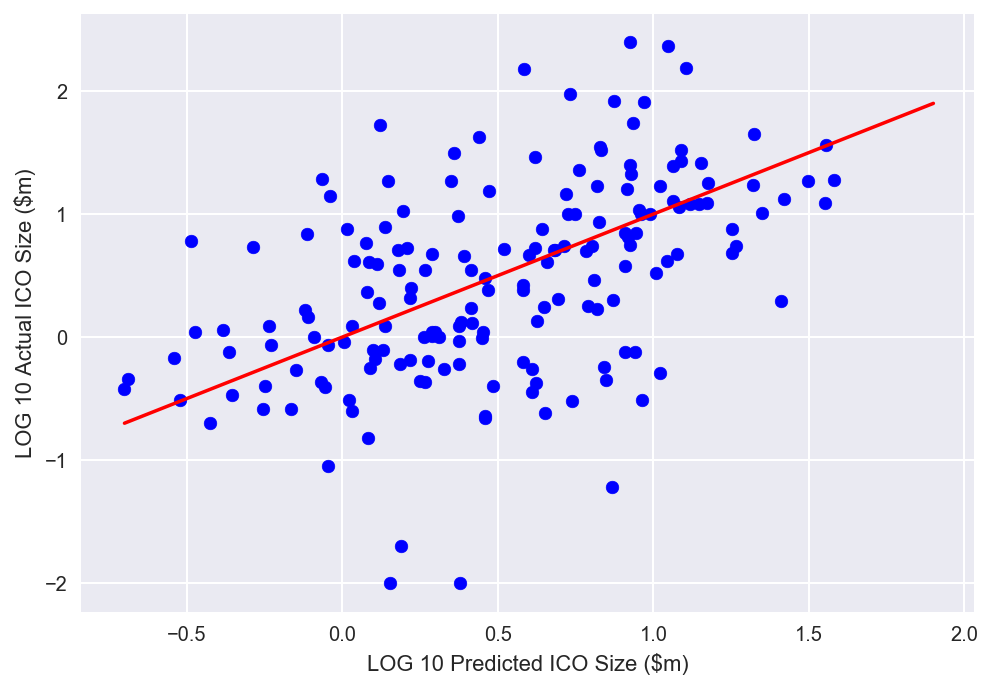

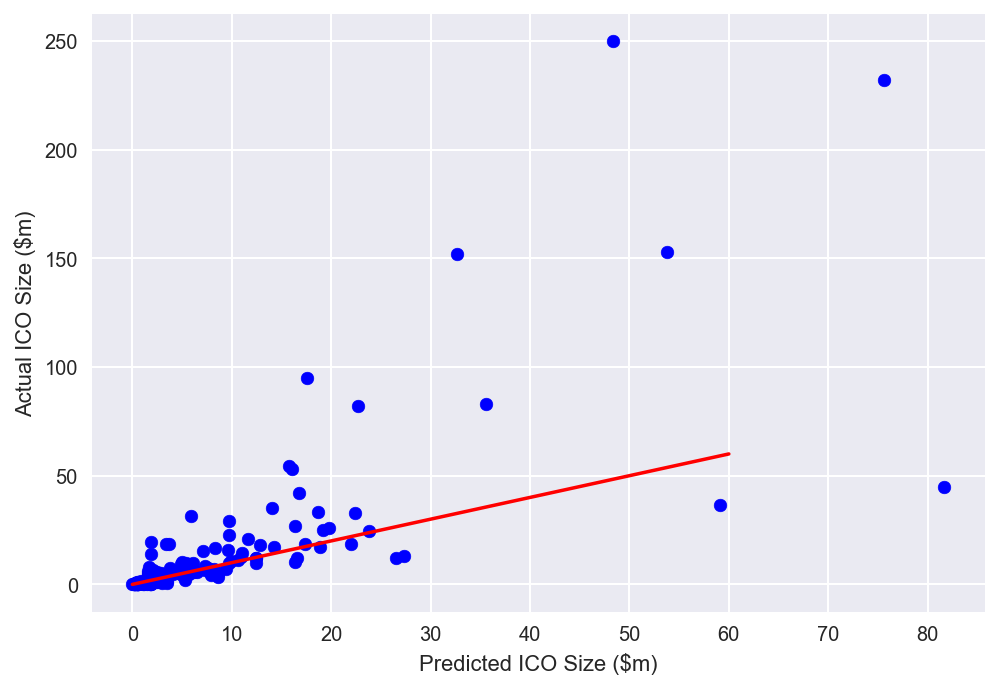

NameError: name 'icodf_filtered' is not defined

In [8]:
from sklearn.feature_selection import RFE
import xgboost as xgbb

#LINEAR SVM

#fare_svr = svm.SVR(kernel='linear', C = 0.7)

#RBF 
#fare_svr = svm.SVR(kernel='rbf', C=1, gamma=0.5)

#GBR

#fare_svr = GradientBoostingRegressor(loss='ls', learning_rate=0.2,  n_estimators=8, max_depth=1)

#XGBOOST
fare_svr = xgbb.XGBRegressor(learning_rate=0.4,  n_estimators=180, max_depth=1, n_jobs=4)

#RGF
# fare_svr = RGFRegressor(max_leaf=180,
#                    algorithm="RGF_Sib",
#                    test_interval=100,
#                    loss="LS",
#                    l2=0.07,
#                    sl2=0.001,
#                    min_samples_leaf=18,
#                    n_iter = 30,
#                    verbose=False)

# Linear model
#fare_svr = linear_model.LinearRegression()

fare_svr.fit(X_transformed, Y_values)
prediction = fare_svr.predict(X_transformed)


n_spl = 10
skf = KFold(n_splits=n_spl)
tr_sc = 0.0
te_sc = 0.0
names_array = np.array(model_data['Name'].values)
open_array = np.array(model_data['Open Date (GMT)'].values)
close_array = np.array(model_data['Close Date (GMT)'].values)
#actual_array = np.array(model_data['ICO Size ($M)'].values)

open_list = []
close_list = []
prediction_list = []
Name_list = []
X_list = []
Y_list = []
for train_ind, test_ind in skf.split(X_transformed, Y_values):
    X_tr, X_te = X_transformed[train_ind], X_transformed[test_ind]
    y_tr, y_te = Y_values[train_ind], Y_values[test_ind]
    
    name_te = names_array[test_ind]
    open_te = open_array[test_ind]
    close_te = close_array[test_ind]
    
    fare_svr.fit(X_tr, y_tr)

    tr_prediction = fare_svr.predict(X_tr)
    te_prediction = fare_svr.predict(X_te)
    
    tr_sc = tr_sc + np.sum(np.power(y_tr - tr_prediction,2.0))/np.size(y_tr)
    te_sc = te_sc + np.sum(np.power(y_te - te_prediction,2.0))/np.size(y_te)
    for i in range(len(y_te)):
        Name_list.append(name_te[i])
        X_list.append(X_te[i])
        Y_list.append(y_te[i])
        prediction_list.append(te_prediction[i])
        open_list.append(open_te[i])
        close_list.append(close_te[i])

print(Name_list)
print(Y_list)
print(prediction_list)
#print(actual_list)
from sklearn.metrics import r2_score
print('r2 score is {:.2f}'.format(r2_score(np.array(Y_list), np.array(prediction_list))))
# RFE (only works for linear kernel)
#selector = RFE(fare_svr, 5, step=1)
#selector = selector.fit(X_transformed, Y_values)
#print('selector support: {}'.format(selector.support_))
#print('selector ranking: {}'.format(selector.ranking_))

# XGBOOST FEATURE IMPORTANCE

#print(fare_svr.feature_importances_)


# transformation: Y_values = np.copy(np.log(0.01 + Y_data)/np.log(10.0))

x_identical = np.linspace(-0.7,1.9,100)
plt.scatter(np.array(prediction_list), np.array(Y_list), s=40, c='b', marker='o')
plt.plot(x_identical,x_identical, c='r')
plt.xlabel('LOG 10 Predicted ICO Size ($m)')
plt.ylabel('LOG 10 Actual ICO Size ($m)')
plt.savefig('ICO_log10_actual_vs_predicted.png', bbox_inches='tight')
plt.show()

x_identical = np.linspace(0,60,100)
plt.scatter(np.power(10.0,prediction)-0.01, np.exp(np.log(10.0)*Y_values)-0.01, s=40, c='b', marker='o')
plt.plot(x_identical,x_identical, c='r')
plt.xlabel('Predicted ICO Size ($m)')
plt.ylabel('Actual ICO Size ($m)')
plt.savefig('ICO_actual_vs_predicted.png', bbox_inches='tight')
plt.show()

print(icodf_filtered[['Name', 'Open Date (GMT)']])

In [9]:
print(fare_svr.feature_importances_)

# 'total_comments',
#                      'has_a_subreddit',
#                      'closed_utc',
#                      'cumulative_raised',
#                      'ico_length',
#                      'derogatory_fraction',
#                      'derogatory_posts',
#                      'average_reddit_posts_sentiment',
#                      'average_comment_sentiment',
#                      'total_expert_comments',
#                      'avg_expert_sentiment',
#                      'total_bitcointalk_comments',
#                      'avg_bitcointalk_sentiment'

[ 0.15555556  0.03333334  0.1         0.          0.11111111  0.06111111
  0.02222222  0.05        0.10555556  0.07222223  0.11666667  0.05555556
  0.11666667]


In [10]:
# Create pandas dataframe for export to csv.
#print(icodf_completed['Name'])
#ico_processed = icodf_completed.drop(icodf_completed.index[49])
outputdf = pd.DataFrame()
# outputdf.loc[:,'Name'] = model_data['Name'].values
# outputdf.loc[:,'Actual'] = model_data['ICO Size ($m)'].values
# outputdf.loc[:,'LogActual'] = np.log(0.01 + model_data['ICO Size ($m)'].values)/np.log(10.0)
# outputdf.loc[:,'Predicted'] = np.abs(np.exp(prediction*np.log(10.0))-0.01)
# outputdf.loc[:,'LogPredicted'] = prediction
# outputdf.loc[:,'StartDate'] = icodf_completed['Open Date (GMT)'].values
# outputdf.loc[:,'EndDate'] = icodf_completed['Close Date (GMT)'].values

outputdf.loc[:,'Name'] = pd.Series(Name_list)
outputdf.loc[:,'Actual'] = pd.Series(np.power(10, np.array(Y_list)) - 0.01)
outputdf.loc[:,'LogActual'] = pd.Series(np.array(Y_list))
outputdf.loc[:,'Predicted'] = pd.Series(np.abs(np.exp(np.array(prediction_list)*np.log(10.0))-0.01))
outputdf.loc[:,'LogPredicted'] = pd.Series(np.array(prediction_list))
outputdf.loc[:,'StartDate'] = pd.Series(open_list)
outputdf.loc[:,'EndDate'] = pd.Series(close_list)

#outputdf = outputdf.drop(outputdf.index[49])
outputdf = outputdf.sort_values('Actual', ascending=False)
#outputdf = outputdf.reindex(columns=['Name'])
print(outputdf)

outputdf.to_csv('model_output.csv')

                      Name        Actual  LogActual  Predicted  LogPredicted  \
169               Filecoin  2.500000e+02   2.397957   8.388881      0.924221   
0                    Tezos  2.320000e+02   2.365507  11.150517      1.047684   
1                   Bancor  1.530000e+02   2.184720  12.693457      1.103922   
2                  The DAO  1.520000e+02   2.181872   3.819225      0.583111   
3                   Status  9.500000e+01   1.977769   5.378861      0.731497   
4                     TenX  8.311000e+01   1.919706   7.459163      0.873272   
5                 PressOne  8.200000e+01   1.913867   9.308370      0.969340   
170                   SALT  5.450000e+01   1.736476   8.614003      0.935709   
6                 MobileGo  5.307000e+01   1.724931   1.313325      0.121667   
171        Enigma Catalyst  4.500000e+01   1.653309  21.028374      1.323012   
7                     SONM  4.200000e+01   1.623353   2.737106      0.438875   
172                Monetha  3.630000e+01

In [296]:
# LOAD ICO PREDICTIONS INTO POSTGRES 
conn = establish_db_connection()
cur = conn.cursor()
for i, row in outputdf.iterrows():
    t = datetime.datetime.strptime(row['EndDate'], '%m/%d/%Y')
    utc_time = int(time.mktime(t.timetuple()))
    cur.execute("""INSERT INTO icoprediction (coinname, closed_utc, raise_predict, raise_actual) VALUES ('{}', {:d}, {:.2f}, {:.2f});""".format(row['Name'], utc_time, row['Predicted'], row['Actual']))
    
conn.commit()
cur.close()
conn.close()

In [11]:
print(outputdf['Name'].sort_values().tolist())

['21 Million', 'ATBcoin', 'AdEx', 'Adel', 'Aeternity', 'Agrello', 'Air', 'Aira', 'Antshares', 'Apptrade', 'Aragon', 'Arcade City', 'Ark', 'Augmentors', 'Augur', 'BOScoin', 'Back to Earth', 'Bancor', 'Basic Attention Token', 'BetKing', 'Beyond the Void', 'BidLend', 'BitcoinGrowthFund', 'Bitquence', 'BlockCDN', 'BlockPay', 'BlockPool', 'Blockchain Capital', 'Blocktix', 'Breakout Coin', 'CashScripter', 'Chain of Points', 'Chronobank', 'Civic', 'Cofound.it', 'CoinDash', 'Contingency', 'Cosmos', 'Cosmos Network', 'Counterparty', 'Creativechain', 'CrypViser', 'CryptoPing', 'DCORP', 'DacPlay', 'Darcrus', 'Decent', 'Dent', 'Dfinity', 'DigixDAO', 'DigixGlobal', 'E4ROW', 'ETCWin', 'EcoBit', 'Edgeless', 'Elastic', 'Embermine', 'EncryptoTel', 'Enigma Catalyst', 'Equibit', 'Eros', 'Ethbits', 'Ether.camp', 'Ethereum', 'Etheroll', 'Exscudo', 'Factom', 'Filecoin', 'First Blood', 'FootballCoin', 'FundYourselfNow', 'GeoFounders', 'GetGems', 'Giga Watt', 'Gilgam', 'Gilgam.es', 'Gnosis', 'Golem', 'Golos',

In [12]:
# PLOT FOR PRESENTATION

print(outputdf.sort_values('EndDate'))

sorted

                   Name  Actual  LogActual  Predicted  LogPredicted  \
146               Obits    0.30  -0.508638   1.037524      0.020164   
149               Tokes    0.25  -0.585027   0.673662     -0.165159   
116             GetGems    0.74  -0.124939   0.422900     -0.363613   
86                Wings    2.07   0.318063   1.637242      0.216757   
61                Augur    5.14   0.711807   1.495735      0.177749   
65              Synereo    4.70   0.673021   1.936322      0.289215   
46          SingularDTV    7.50   0.875640   4.381729      0.642636   
44                Golem    8.60   0.935003   6.693774      0.826319   
88               Komodo    1.98   0.298853   7.383562      0.868854   
96               ETCWin    1.31   0.120574   2.392747      0.380708   
121         Arcade City    0.64  -0.187087   1.645680      0.218976   
144     Beyond the Void    0.33  -0.468521   0.432808     -0.353785   
150         MassNetwork    0.25  -0.585027   0.547439     -0.253803   
109   

101   2014-02-03
60    2014-05-21
131   2014-07-19
149   2014-08-17
27    2014-09-02
92    2014-09-22
143   2014-12-03
130   2015-01-04
139   2015-02-21
136   2015-04-30
142   2015-05-14
144   2015-09-01
70    2015-10-01
147   2015-12-20
160   2016-01-01
61    2016-03-21
64    2016-03-28
63    2016-03-29
145   2016-04-01
148   2016-05-01
3     2016-05-01
95    2016-05-17
121   2016-06-01
32    2016-06-01
117   2016-06-04
140   2016-07-07
138   2016-07-16
127   2016-07-30
155   2016-07-30
125   2016-08-16
         ...    
169   2017-07-14
6     2017-07-15
10    2017-07-15
111   2017-07-16
76    2017-07-16
54    2017-07-17
26    2017-07-17
167   2017-07-20
166   2017-07-20
88    2017-07-21
74    2017-07-23
58    2017-07-26
165   2017-07-26
81    2017-07-26
82    2017-07-28
86    2017-07-28
25    2017-07-31
132   2017-07-31
36    2017-08-01
94    2017-08-01
13    2017-08-03
57    2017-08-07
19    2017-08-10
18    2017-08-17
7     2017-08-22
107   2017-08-24
137   2017-08-24
11    2017-08-

/Users/christle/anaconda3/envs/insight_env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


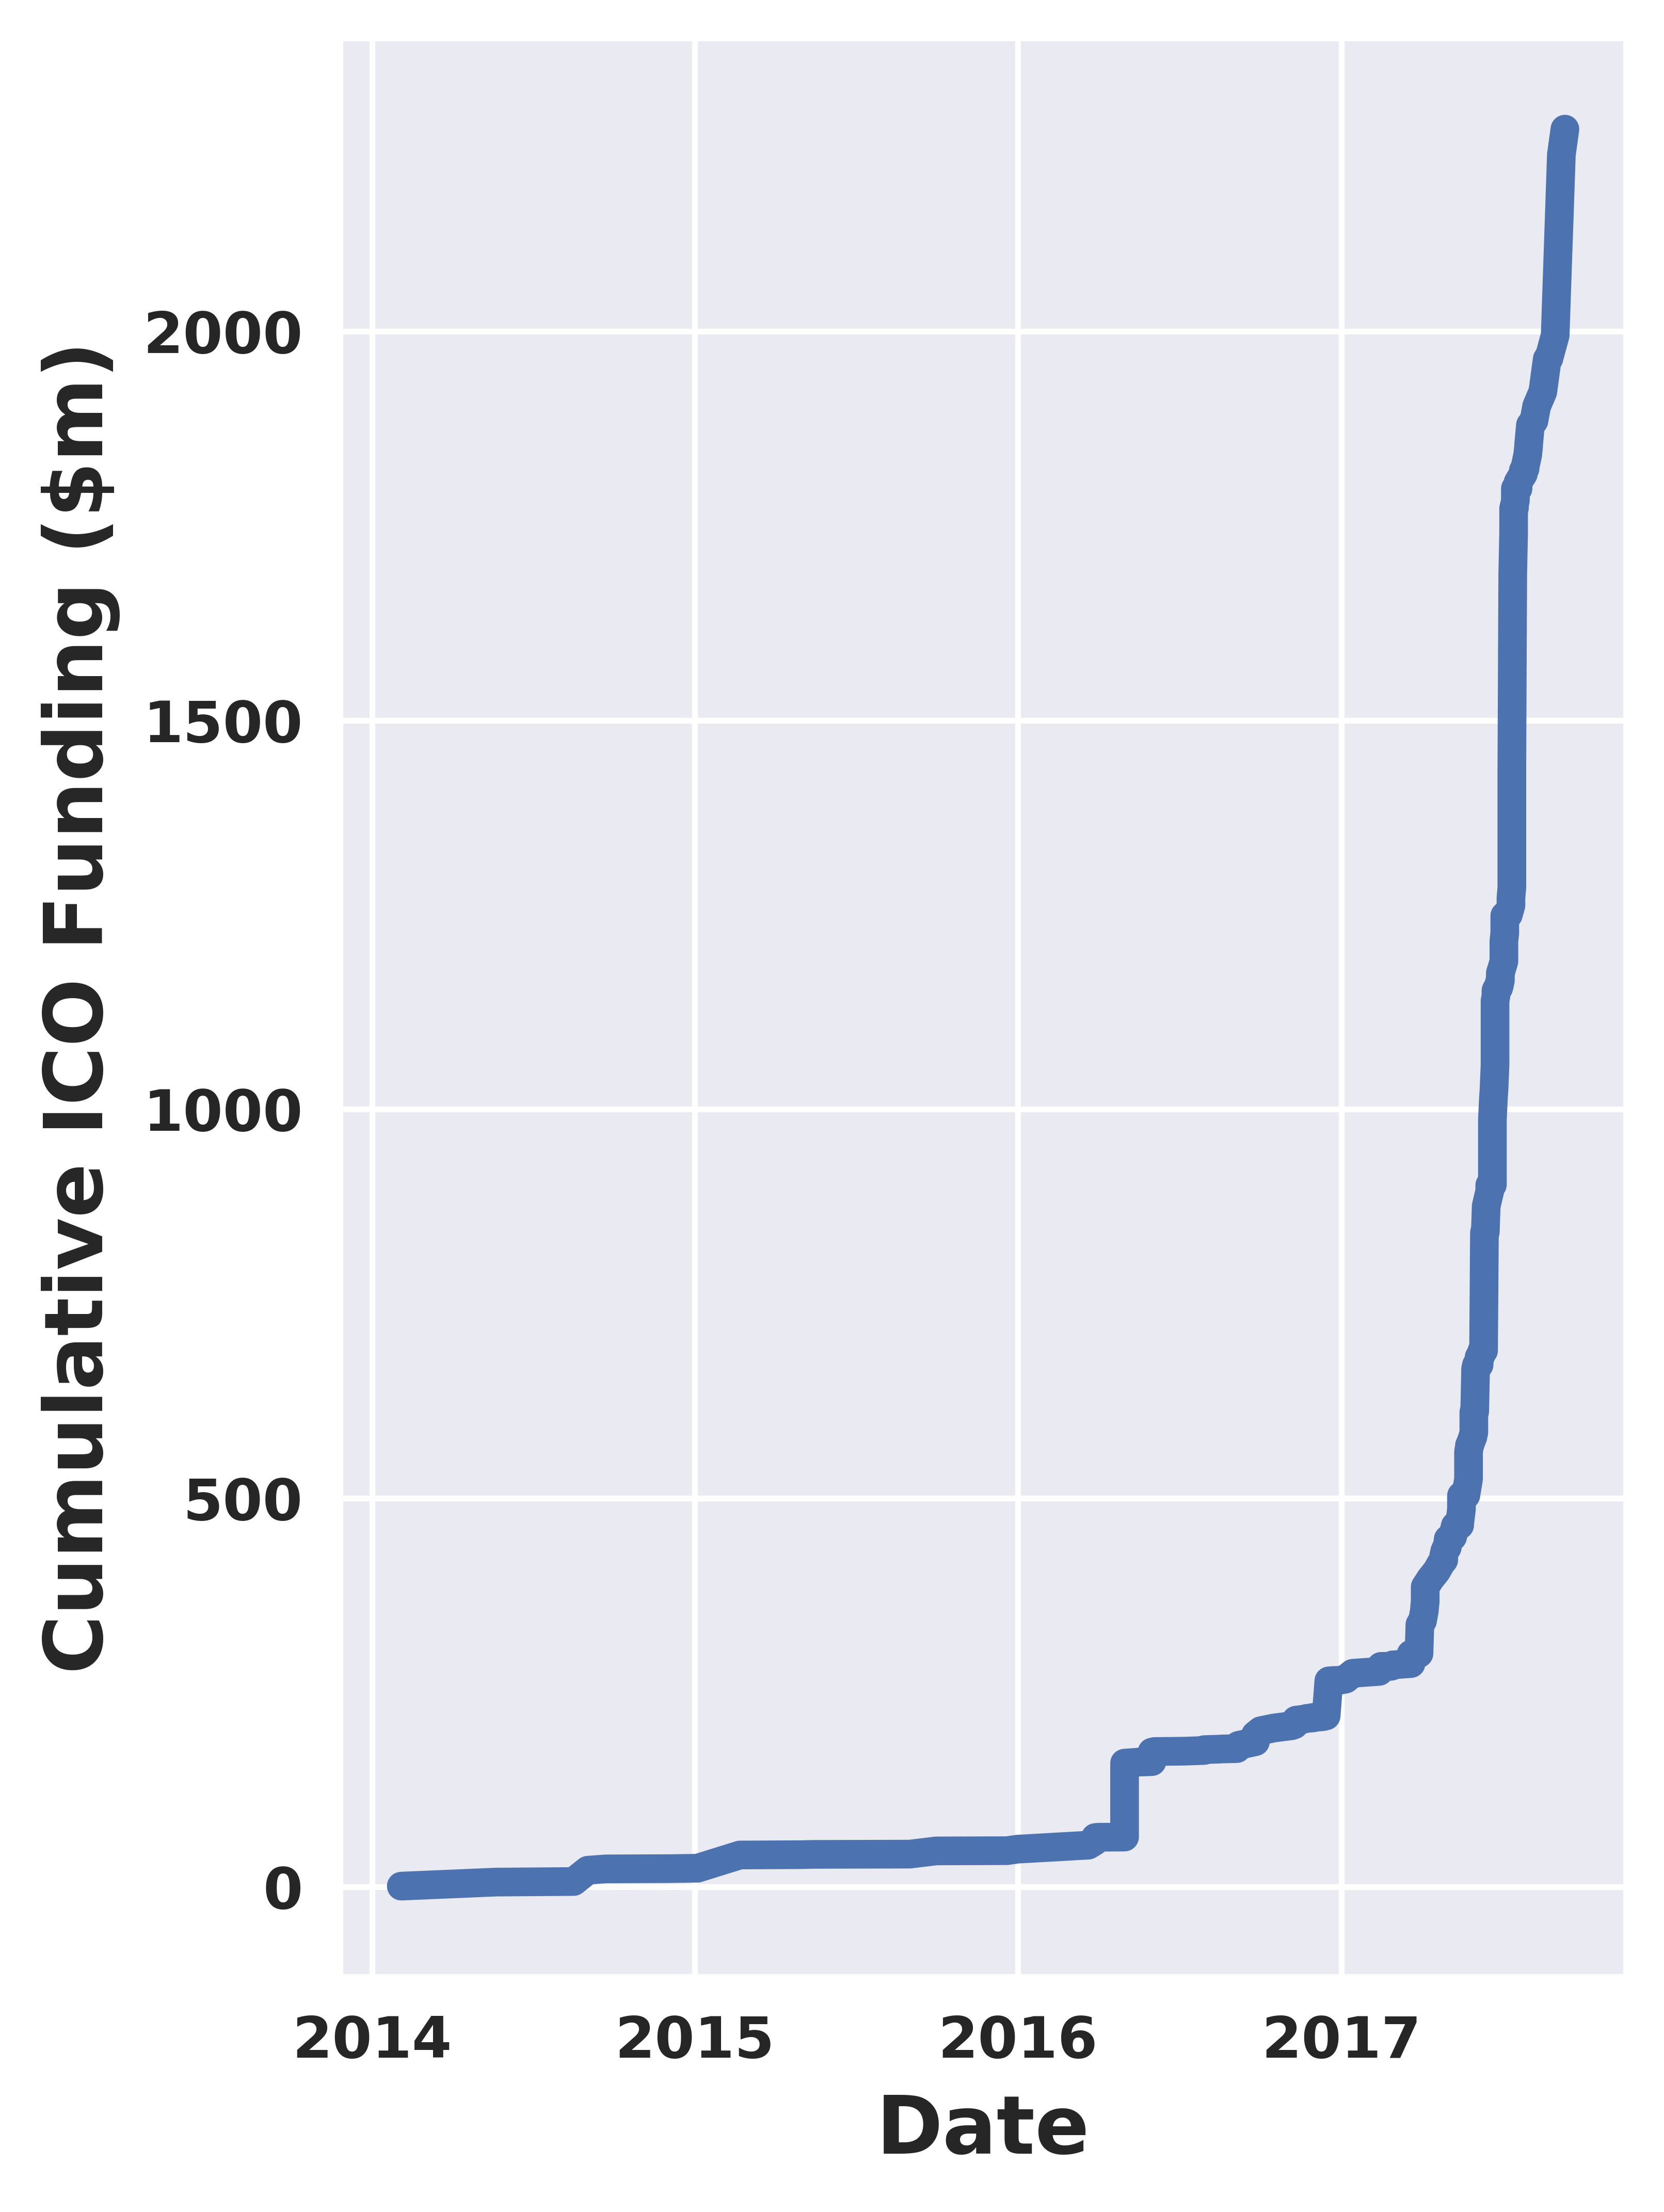

In [53]:
import matplotlib.pyplot as plt
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14


sorteddf = outputdf
sorteddf['converted'] = pd.Series([datetime.datetime.strptime(elem, '%m/%d/%Y') for elem in sorteddf['EndDate'].values])

sorteddf = sorteddf.sort_values('converted')

width, height = plt.figaspect(1.55)
fig = plt.figure(figsize=(width,height), dpi=400)
ax = plt.subplot(111)

converted_dates = [datetime.datetime.strptime(elem, '%m/%d/%Y') for elem in sorteddf['EndDate'].values]
ax.plot(sorteddf['converted'],np.cumsum(sorteddf['Actual'].values), linewidth=5)
ax.set_xlabel('Date')
print(sorteddf['converted'])
ax.set_ylabel('Cumulative ICO Funding ($m)')
plt.xticks([datetime.datetime.strptime('01/01/2014', '%m/%d/%Y'), datetime.datetime.strptime('01/01/2015', '%m/%d/%Y'), datetime.datetime.strptime('01/01/2016', '%m/%d/%Y'), datetime.datetime.strptime('01/01/2017', '%m/%d/%Y')], ['2014', '2015', '2016', '2017'])
plt.savefig('ico_cumulative.png', bbox_inches='tight')
plt.show()

